# Forecasting Prices Using Stock Market Index Data


## Import Libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from warnings import filterwarnings

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")


## Data Cleaning


### Load the Data


In [2]:
# Load the stock data and check whether it has been loaded correctly.
data = pd.read_csv(
    "data/index_data.csv",
    on_bad_lines="error",
)


### Convert Date Column to Datetime


In [3]:
data["Date"] = pd.to_datetime(data["Date"])
print("Data Info Overview:")
data.info()


Data Info Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Index      112457 non-null  object        
 1   Date       112457 non-null  datetime64[ns]
 2   Open       110253 non-null  float64       
 3   High       110253 non-null  float64       
 4   Low        110253 non-null  float64       
 5   Close      110253 non-null  float64       
 6   Adj Close  110253 non-null  float64       
 7   Volume     110253 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


### Remove Incomplete Rows


In [4]:
# Count how many missing values are in each column.
print("Number of Missing Values Per Column:")
display(data.isnull().sum())

# Remove rows with missing values.
data.dropna(axis=0, how="any", inplace=True)

# Check that the missing values have been removed.
print("Number of Missing Values Per Column After Cleaning:")
display(data.isnull().sum())


Number of Missing Values Per Column:


Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64

Number of Missing Values Per Column After Cleaning:


Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Remove Rows with Missing Volume


In [5]:
# Exclude days with missing volume, as this will skew the distribution of the
# data.
print(f"Number of Rows Before Excluding Days with Missing Volume: {len(data)}")
data = data.loc[data["Volume"] != 0]
print("Number of Rows After Excluding Days with Missing " f"Volume: {len(data)}")


Number of Rows Before Excluding Days with Missing Volume: 110253
Number of Rows After Excluding Days with Missing Volume: 68160


## Data Exploration


### Explore the Index Information


In [6]:
# Load the index info to understand what each index ticker represents.
index_info = pd.read_csv(
    "data/index_info.csv",
    on_bad_lines="error",
)
display(index_info)


Region                          Exchange      Index Currency
0   United States           New York Stock Exchange        NYA      USD
1   United States                            NASDAQ       IXIC      USD
2       Hong Kong          Hong Kong Stock Exchange        HSI      HKD
3           China           Shanghai Stock Exchange  000001.SS      CNY
4           Japan              Tokyo Stock Exchange       N225      JPY
5          Europe                          Euronext       N100      EUR
6           China           Shenzhen Stock Exchange  399001.SZ      CNY
7          Canada            Toronto Stock Exchange     GSPTSE      CAD
8           India  National Stock Exchange of India       NSEI      INR
9         Germany          Frankfurt Stock Exchange      GDAXI      EUR
10          Korea                    Korea Exchange       KS11      KRW
11    Switzerland                SIX Swiss Exchange       SSMI      CHF
12         Taiwan             Taiwan Stock Exchange       TWII      TWD
13   South Africa       Johannesburg Stock Exchange    J203.JO      ZAR

### Split the Data by Index


In [7]:
# Split the dataset by 'Index' column.
data_frames_per_index = {
    key: data.loc[value] for key, value in data.groupby("Index").groups.items()
}

# Show how many rows of data are available for each index.
print("Sample Size Per Index:")
for index, data_frame in data_frames_per_index.items():
    print(f"{index}: {len(data_frame)}")


Sample Size Per Index:
000001.SS: 4430
399001.SZ: 4190
GDAXI: 5464
GSPTSE: 9183
HSI: 4890
IXIC: 9233
KS11: 6029
N100: 3817
N225: 4635
NSEI: 2026
NYA: 5115
SSMI: 4632
TWII: 4516


### Calculate Distribution of Features



Distribution of Features in Nasdaq Composite:


Open          High           Low         Close     Adj Close  \
count   9233.000000   9233.000000   9233.000000   9233.000000   9233.000000   
mean    2674.264204   2692.163699   2653.589646   2674.099046   2674.099046   
std     2605.349472   2622.051911   2585.879459   2605.468119   2605.468119   
min      238.000000    238.399994    237.699997    238.100006    238.100006   
25%      730.059998    732.969971    727.609985    730.799988    730.799988   
50%     2012.869995   2029.270020   1993.739990   2009.880005   2009.880005   
75%     3229.810059   3249.780029   3195.570068   3222.370117   3222.370117   
max    14204.509770  14211.570310  14064.280270  14138.780270  14138.780270   

             Volume  
count  9.233000e+03  
mean   1.362774e+09  
std    1.094822e+09  
min    3.884000e+07  
25%    2.722500e+08  
50%    1.584200e+09  
75%    1.983830e+09  
max    1.110216e+10

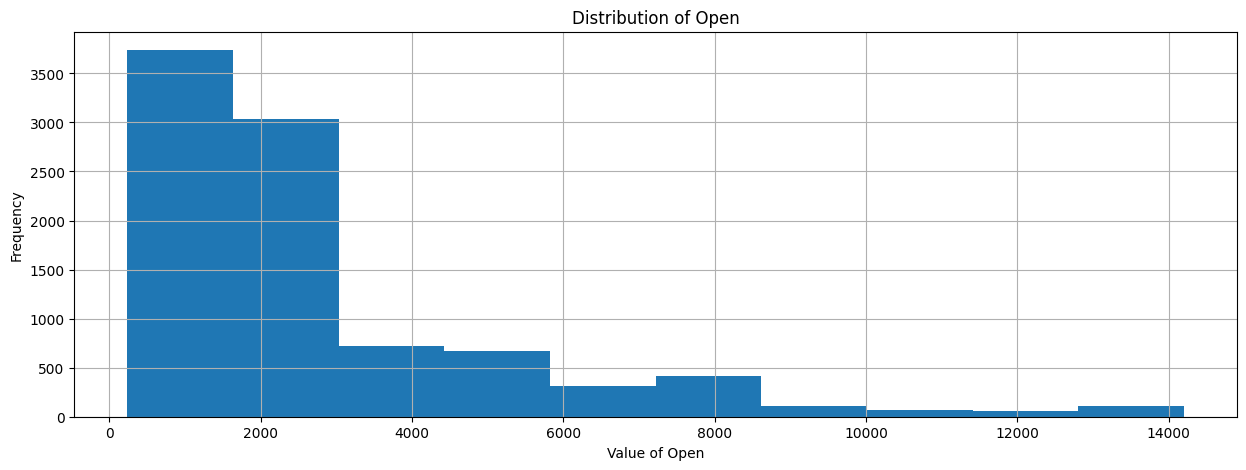

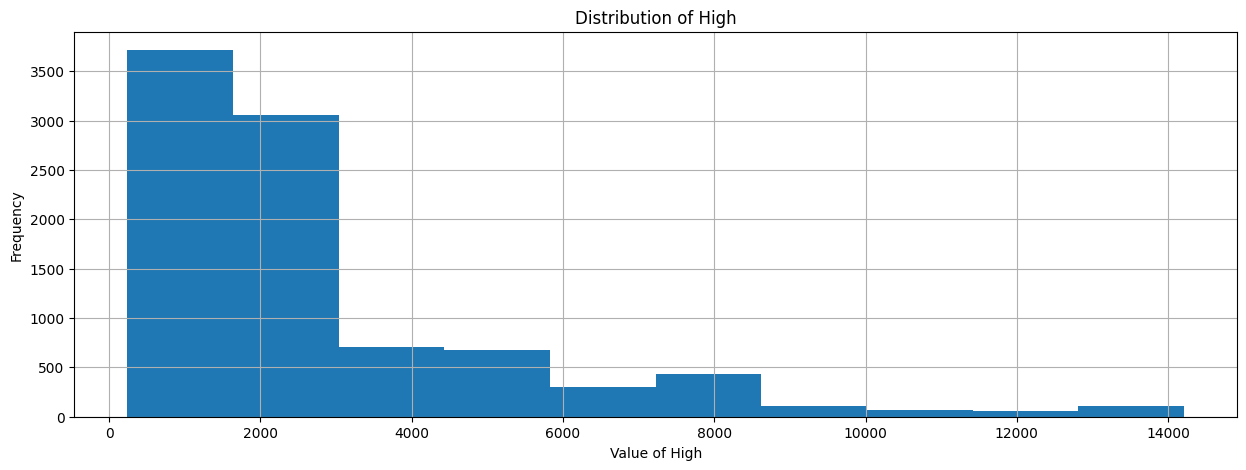

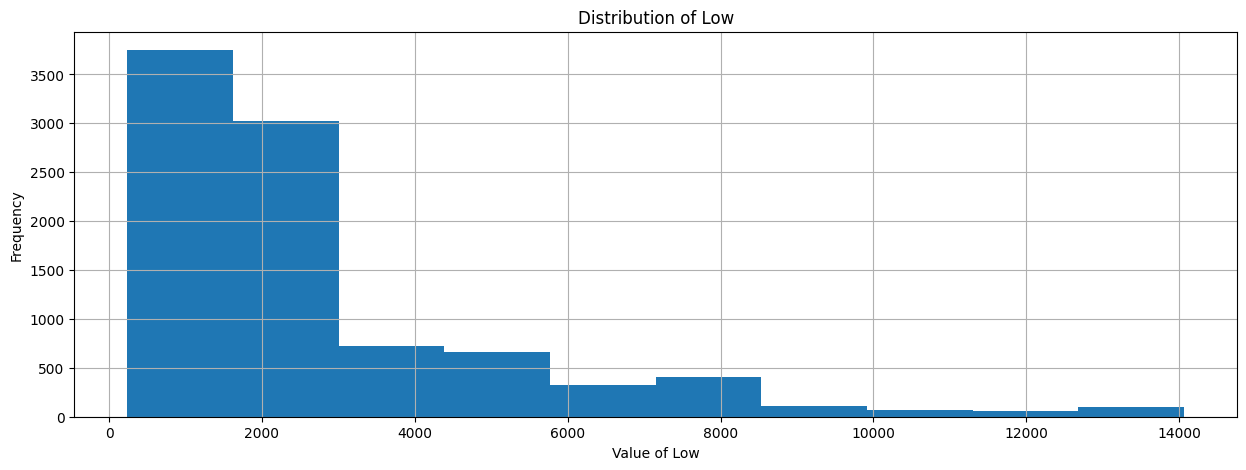

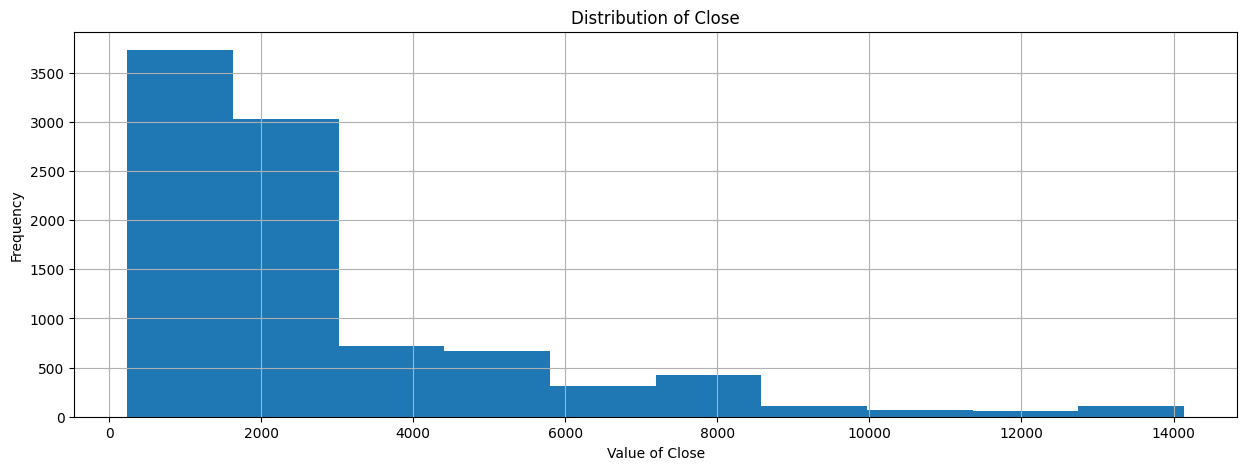

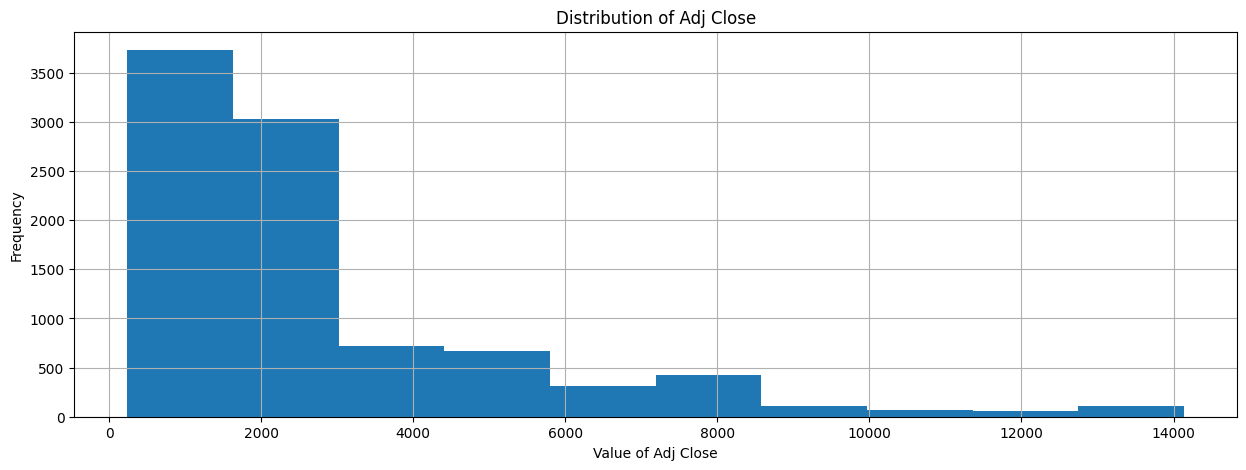

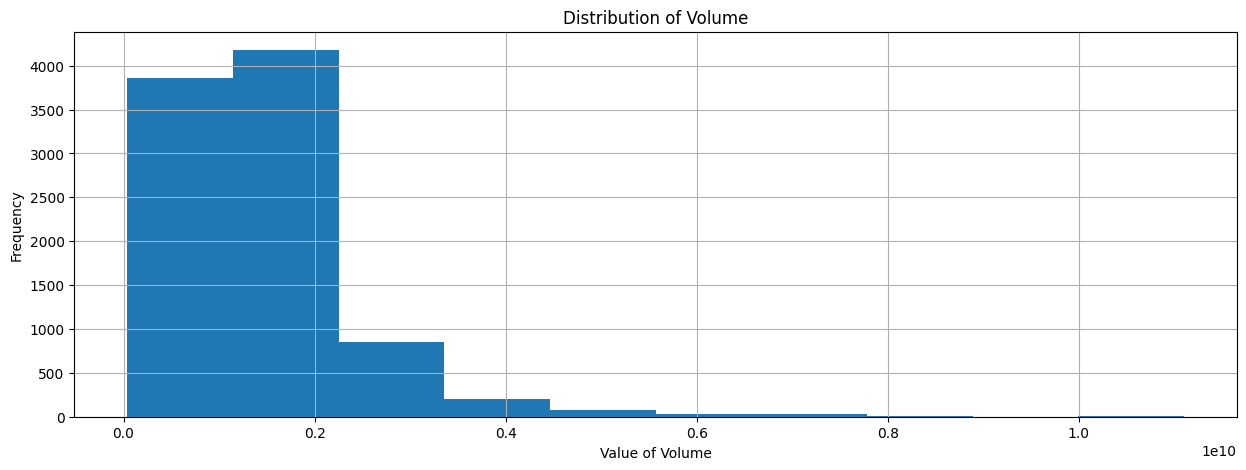

<AxesSubplot: title={'center': 'Daily Volume Traded Over Time in Nasdaq Composite'}, xlabel='Date', ylabel='Daily Volume Traded'>

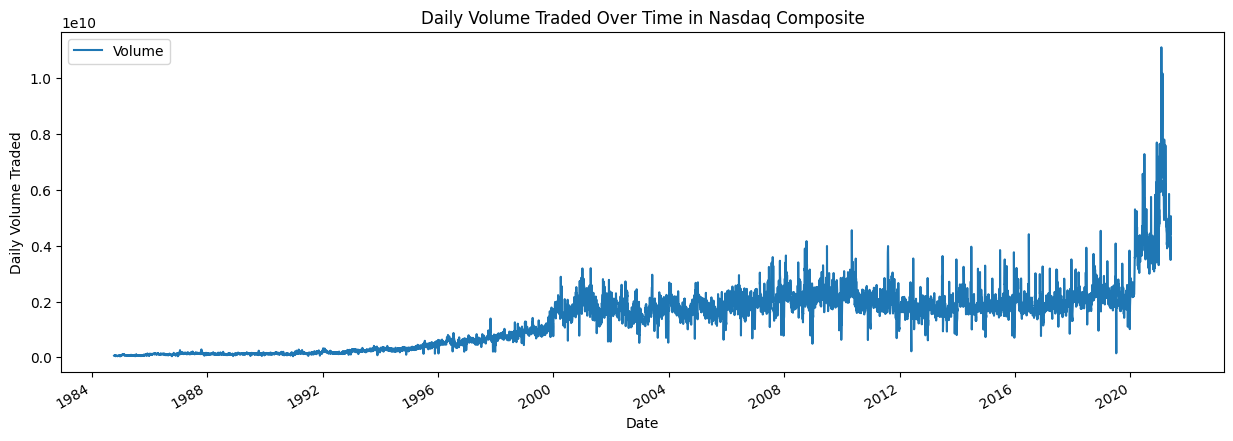

In [8]:
# Focus on the IXIC (Nasdaq Composite) data to simplify our analysis.
ixic_data = data_frames_per_index["IXIC"]

print("\nDistribution of Features in Nasdaq Composite:")
display(ixic_data.describe())
# Create a histogram of each feature to see the distribution of the data.
for column in ixic_data.columns:
    # Skip the index and date columns as they're metadata rather than features.
    if column not in ["Index", "Date"]:
        plt.figure(figsize=(15, 5))
        ixic_data[column].hist()
        plt.title(f"Distribution of {column}")
        plt.xlabel(f"Value of {column}")
        plt.ylabel("Frequency")
    plt.show()

# Visualise daily volume traded over time in Nasdaq Composite.
ixic_data.plot(
    x="Date",
    y="Volume",
    xlabel="Date",
    ylabel="Daily Volume Traded",
    title="Daily Volume Traded Over Time in Nasdaq Composite",
    figsize=(15, 5),
)


### Identify Feature Importance


Correlation of Features to Adjusted Close Price in Nasdaq Composite


Close        1.000000
Adj Close    1.000000
Low          0.999934
High         0.999924
Open         0.999872
Volume       0.784782
Name: Adj Close, dtype: float64

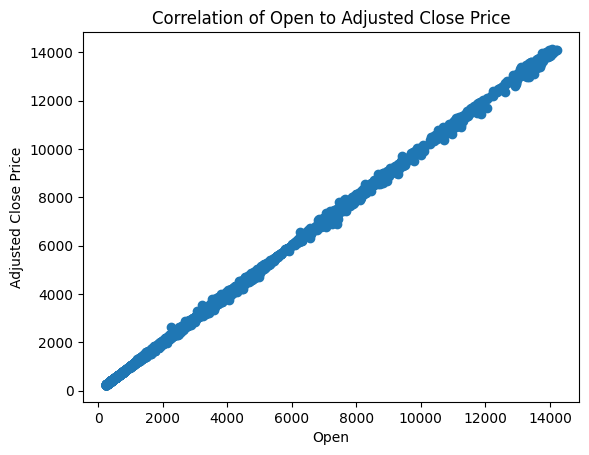

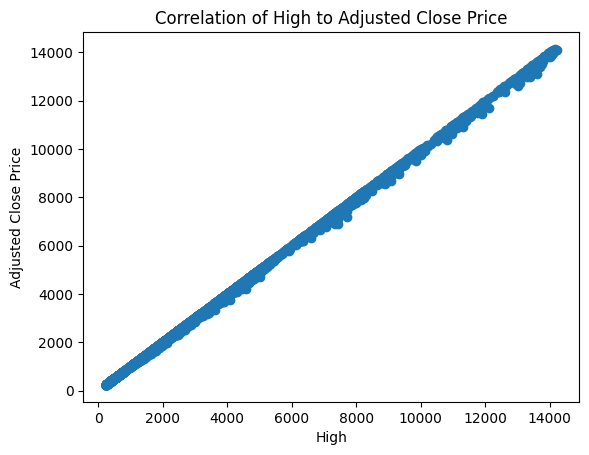

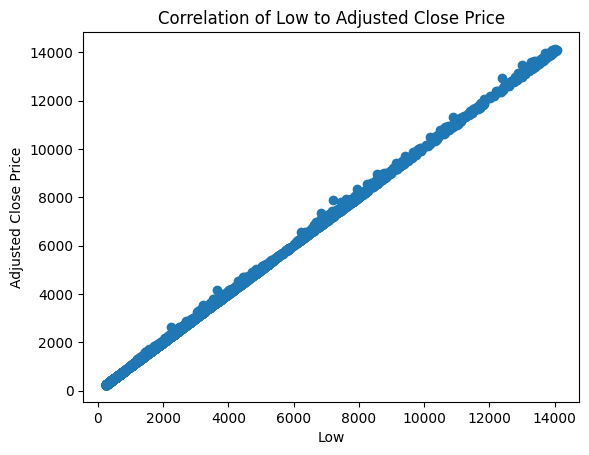

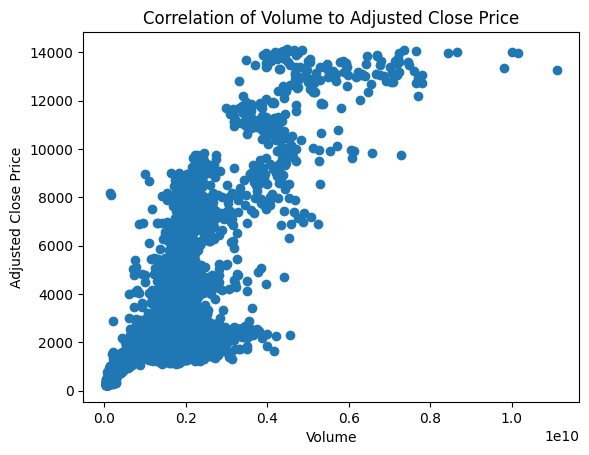

In [9]:
# Show how each feature contributes to the target variable of adjusted close
# price for each index.
print(f"Correlation of Features to Adjusted Close Price in Nasdaq Composite")
display(ixic_data.corr(numeric_only=True)["Adj Close"].sort_values(ascending=False))

# Visualise the correlation between each feature and the adjusted close price.
for feature in ixic_data.columns:
    # Skip the index and date columns as they're metadata rather than features.
    if feature not in ["Index", "Date", "Adj Close", "Close"]:
        plt.scatter(ixic_data[feature], ixic_data["Adj Close"])
        plt.xlabel(feature)
        plt.ylabel("Adjusted Close Price")
        plt.title(f"Correlation of {feature} to Adjusted Close Price")
        plt.show()


## Feature Engineering


### Calculate Simple Moving Averages


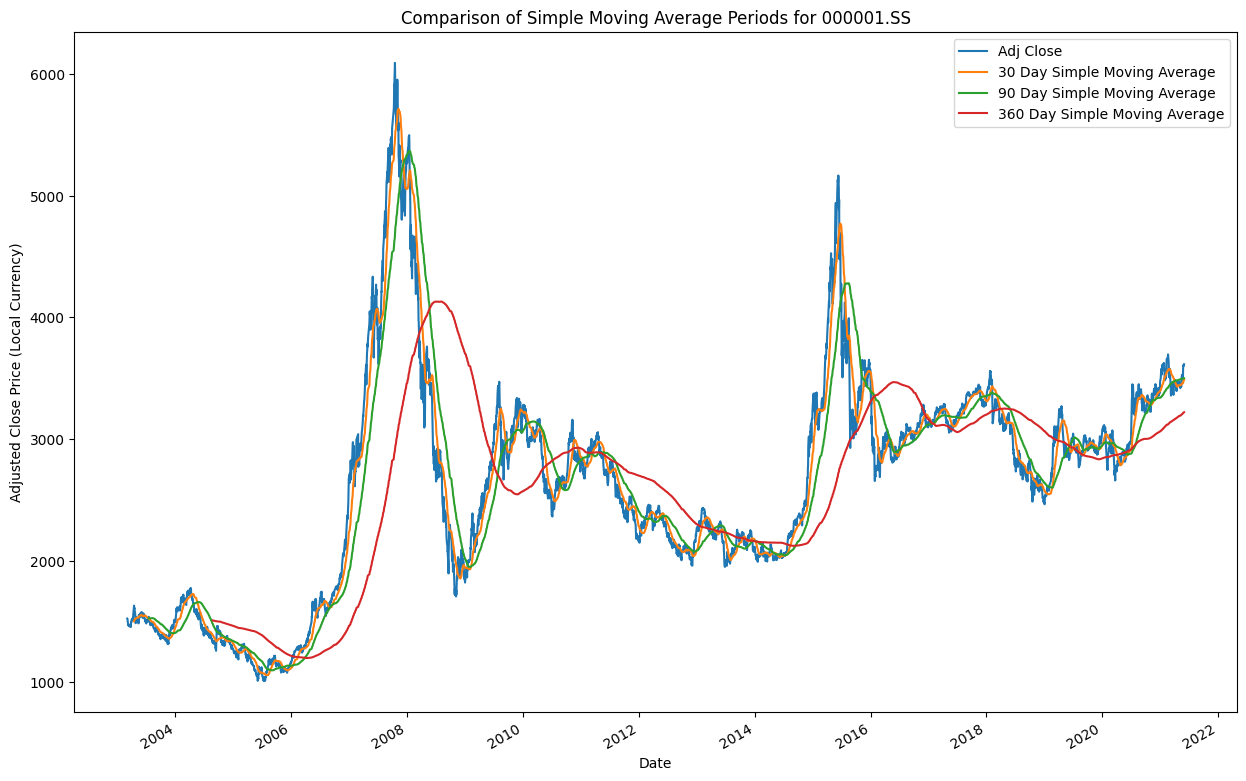

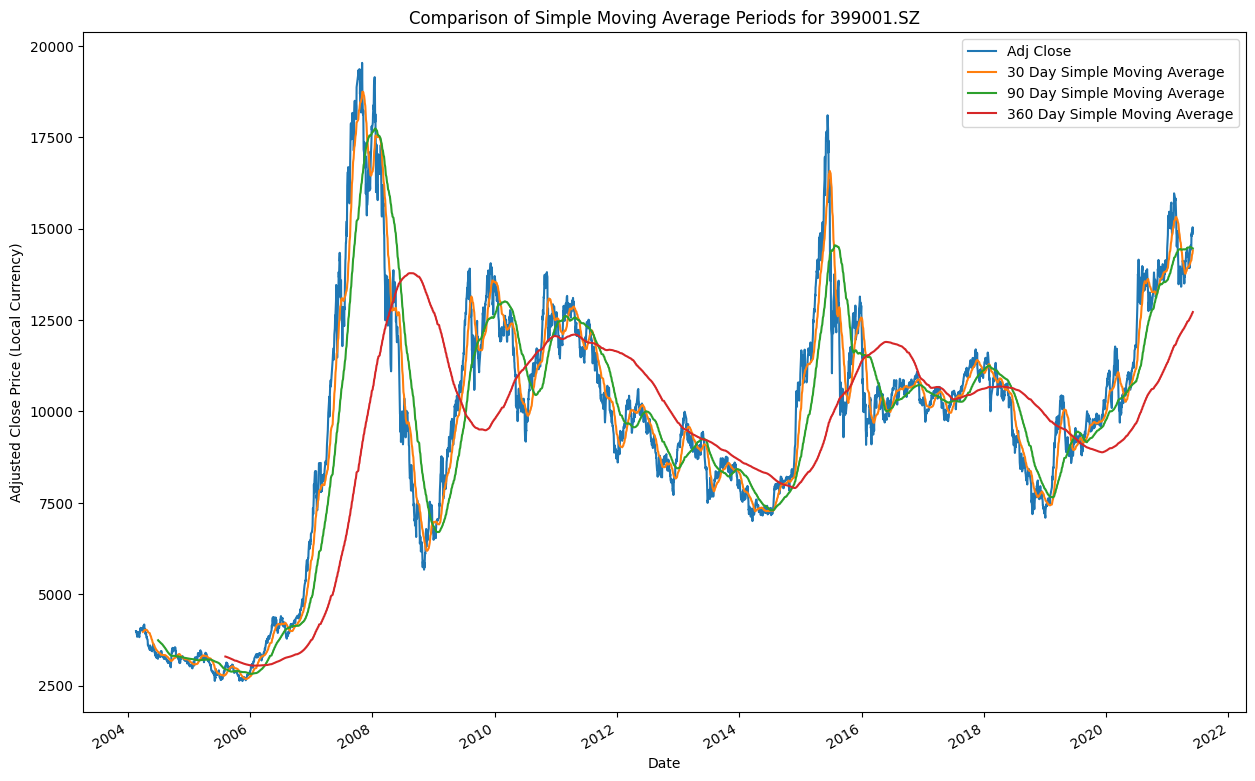

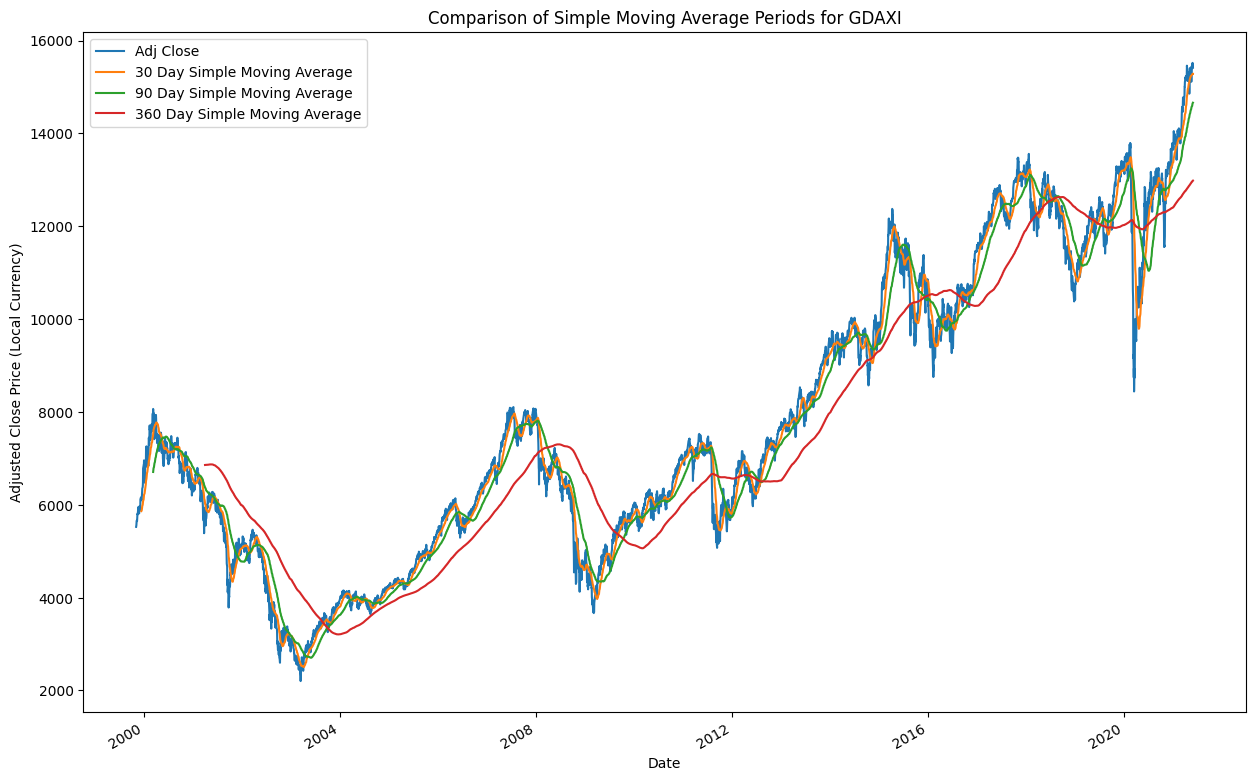

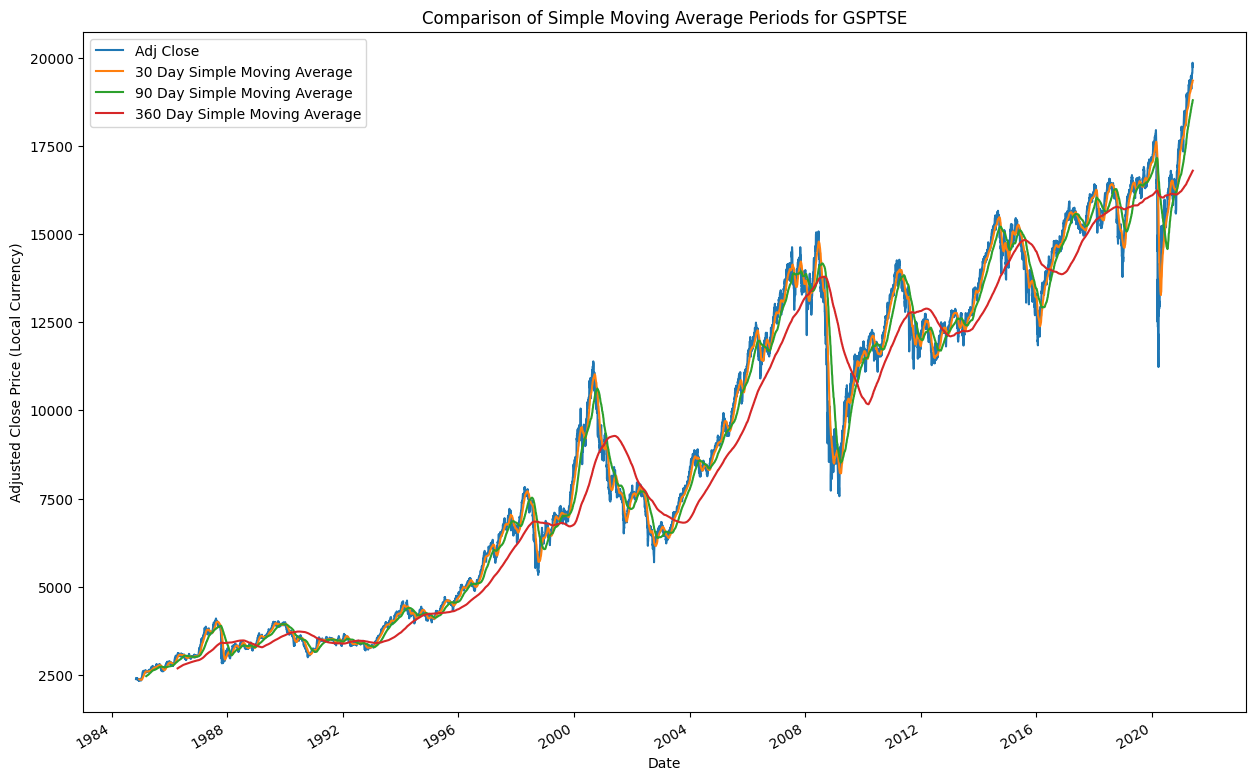

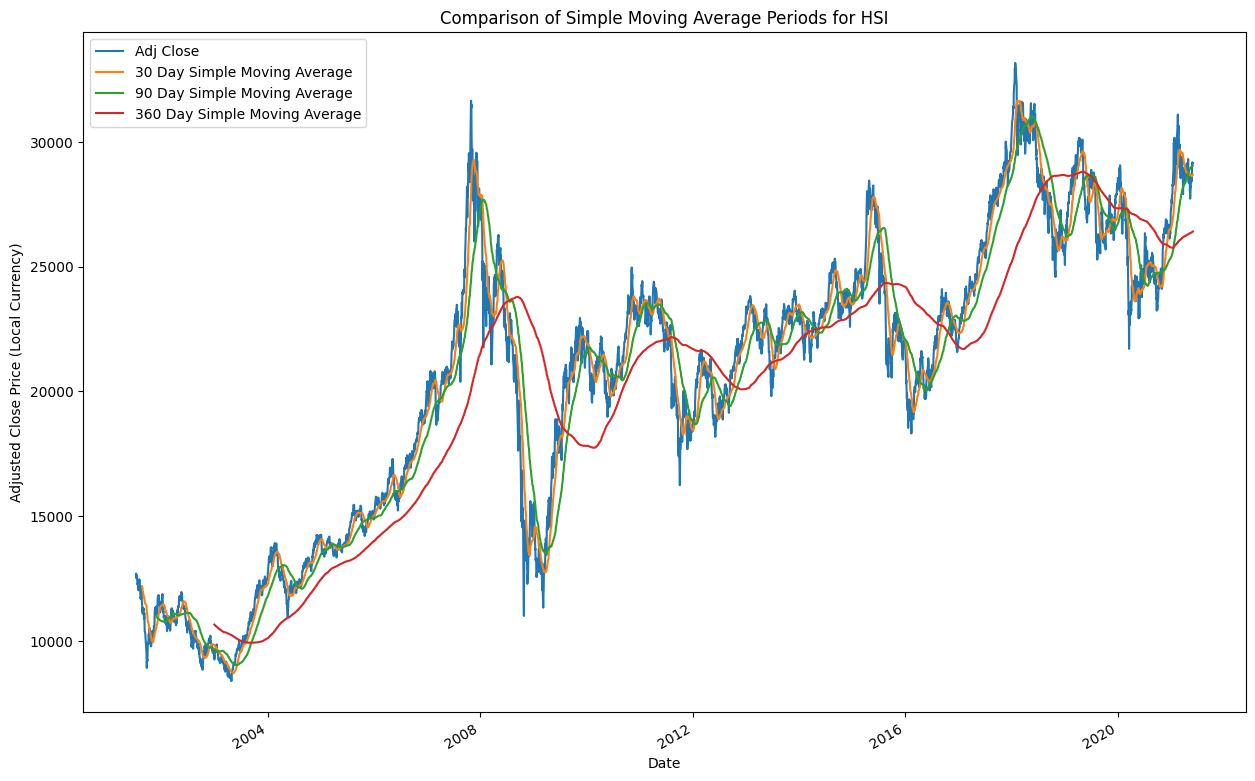

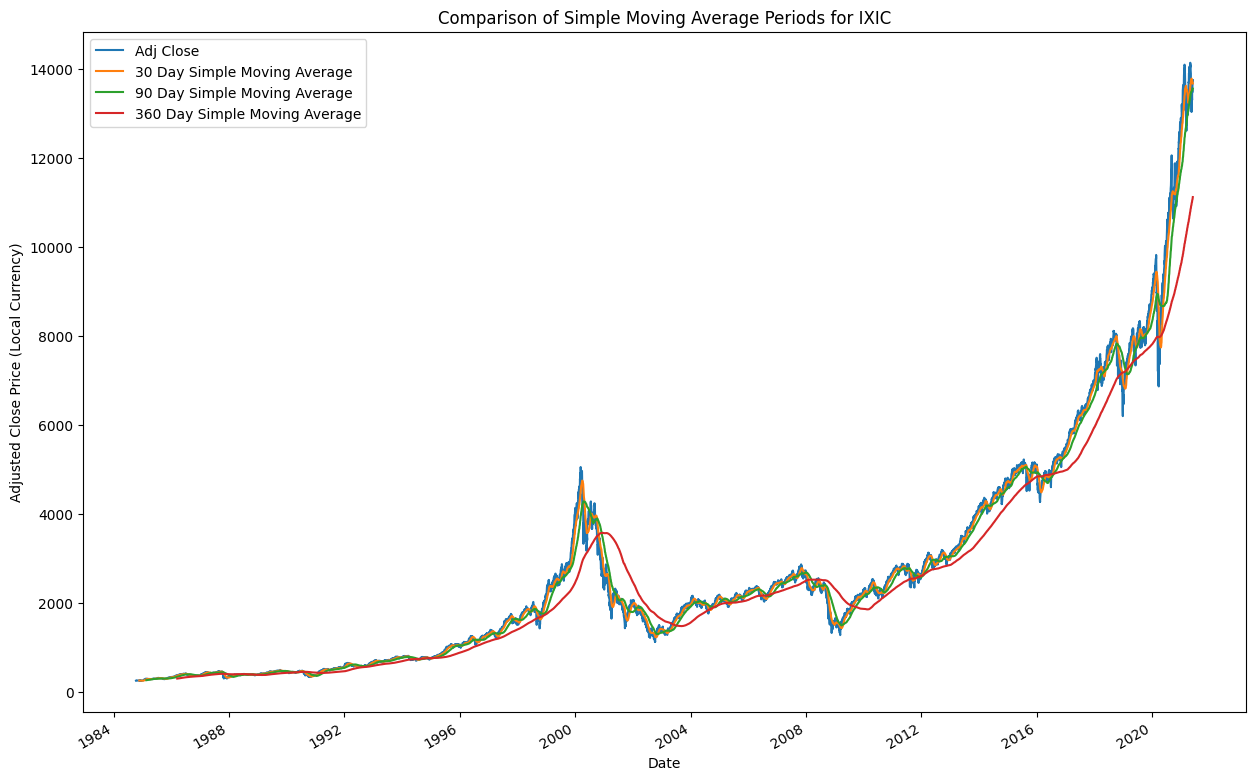

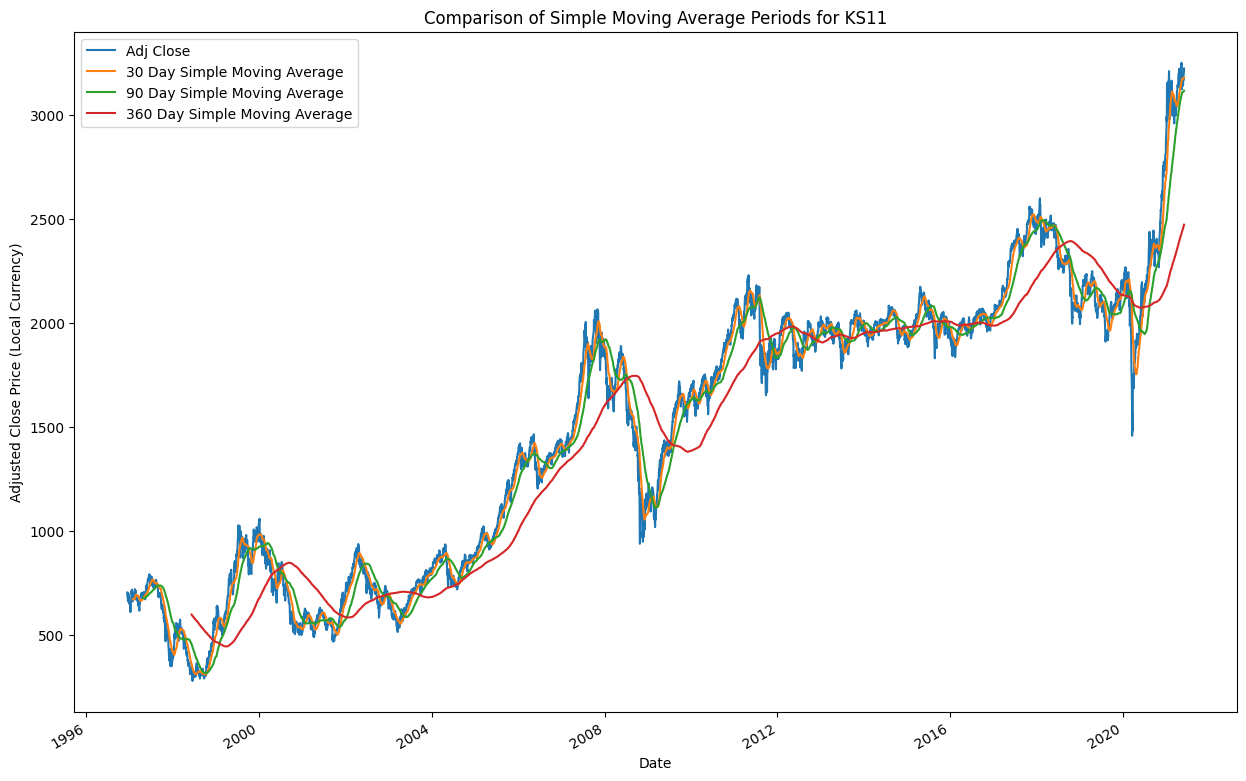

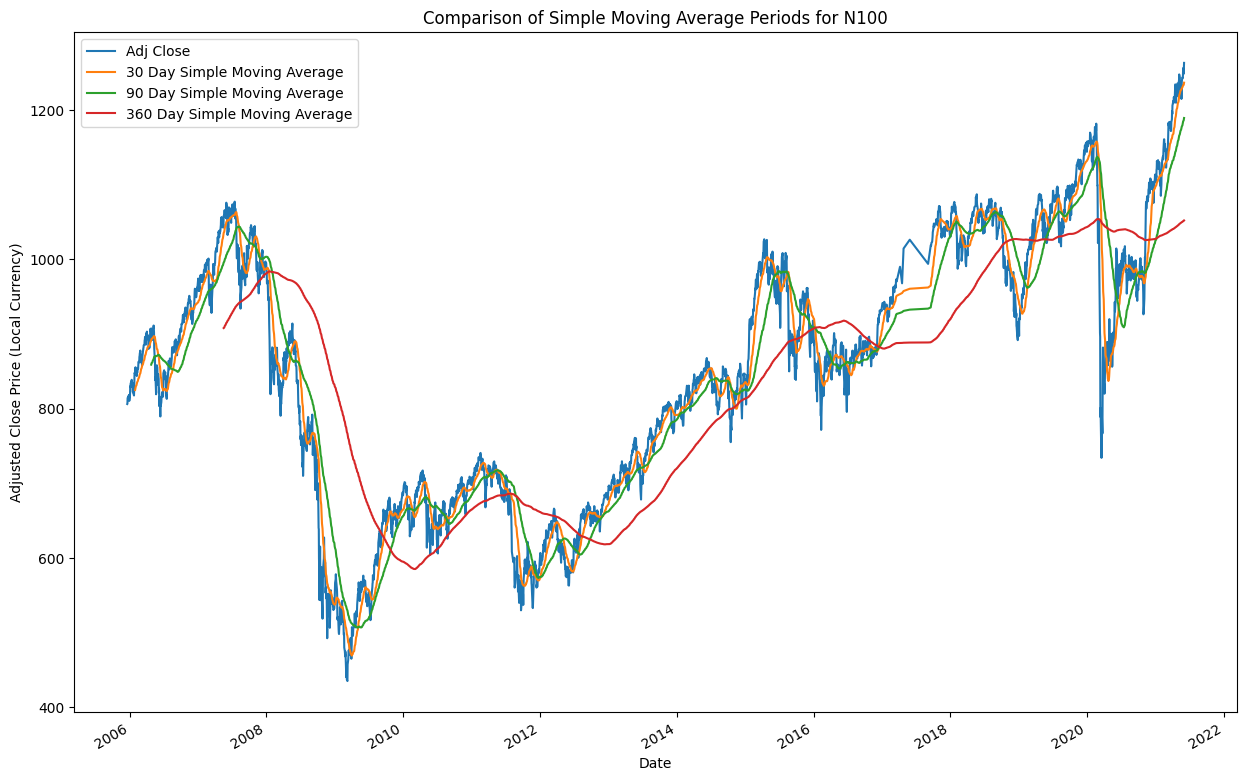

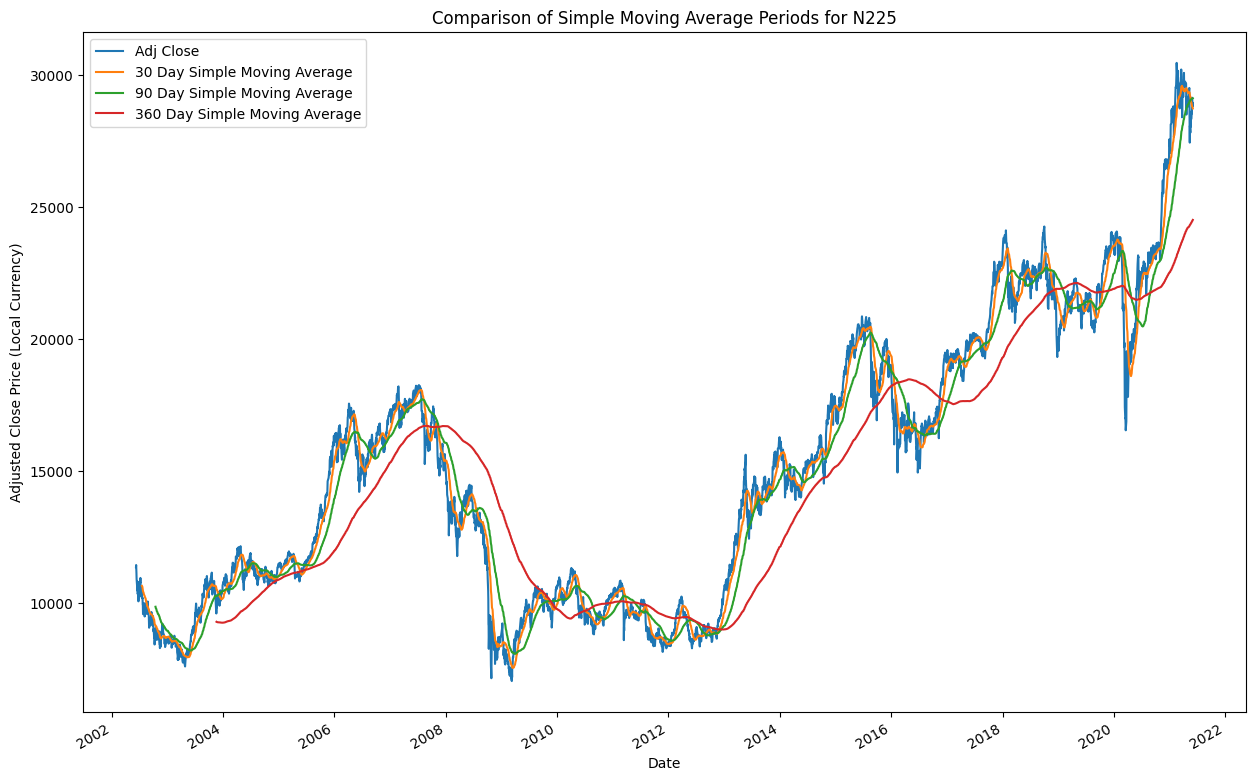

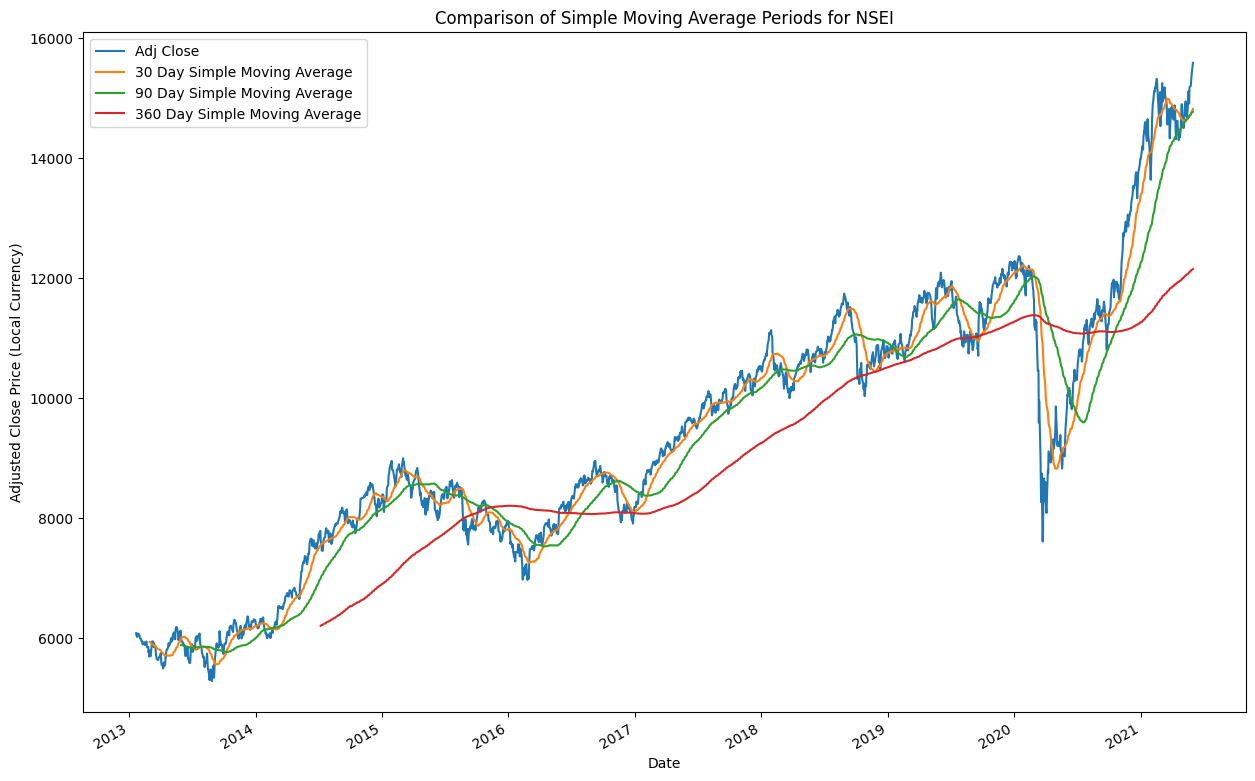

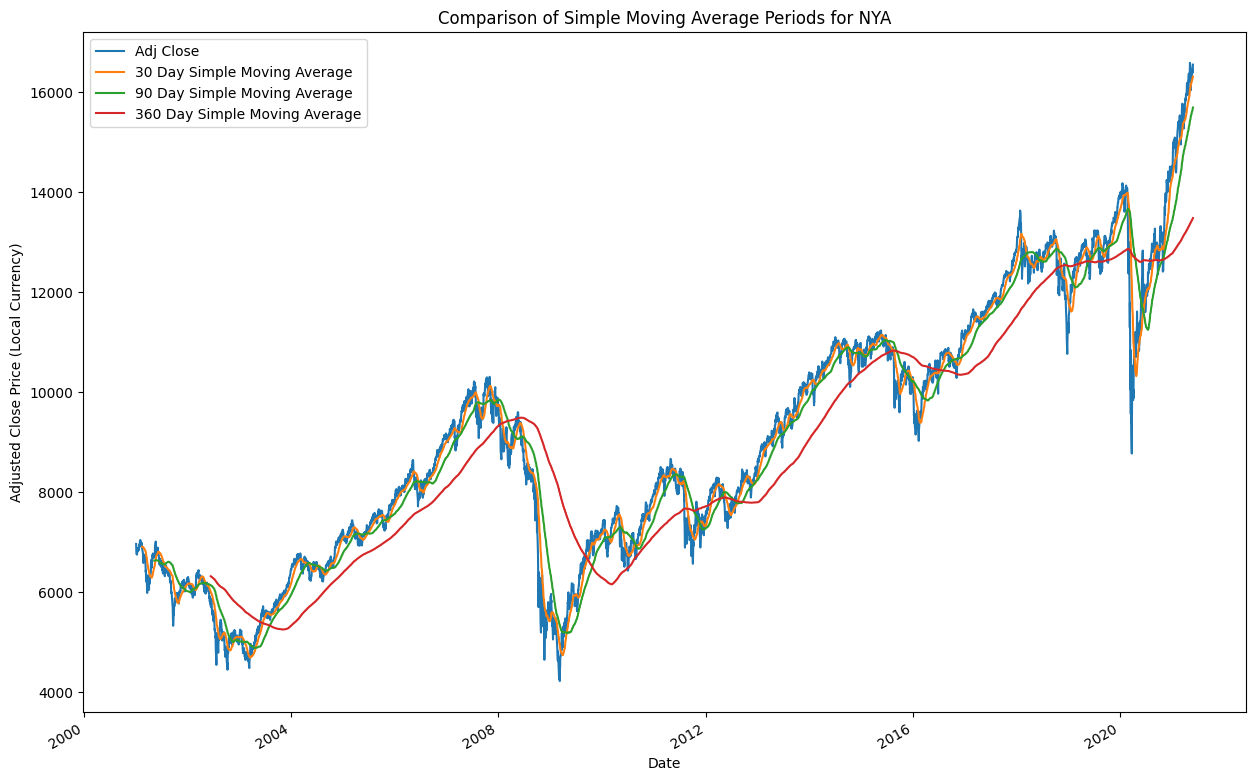

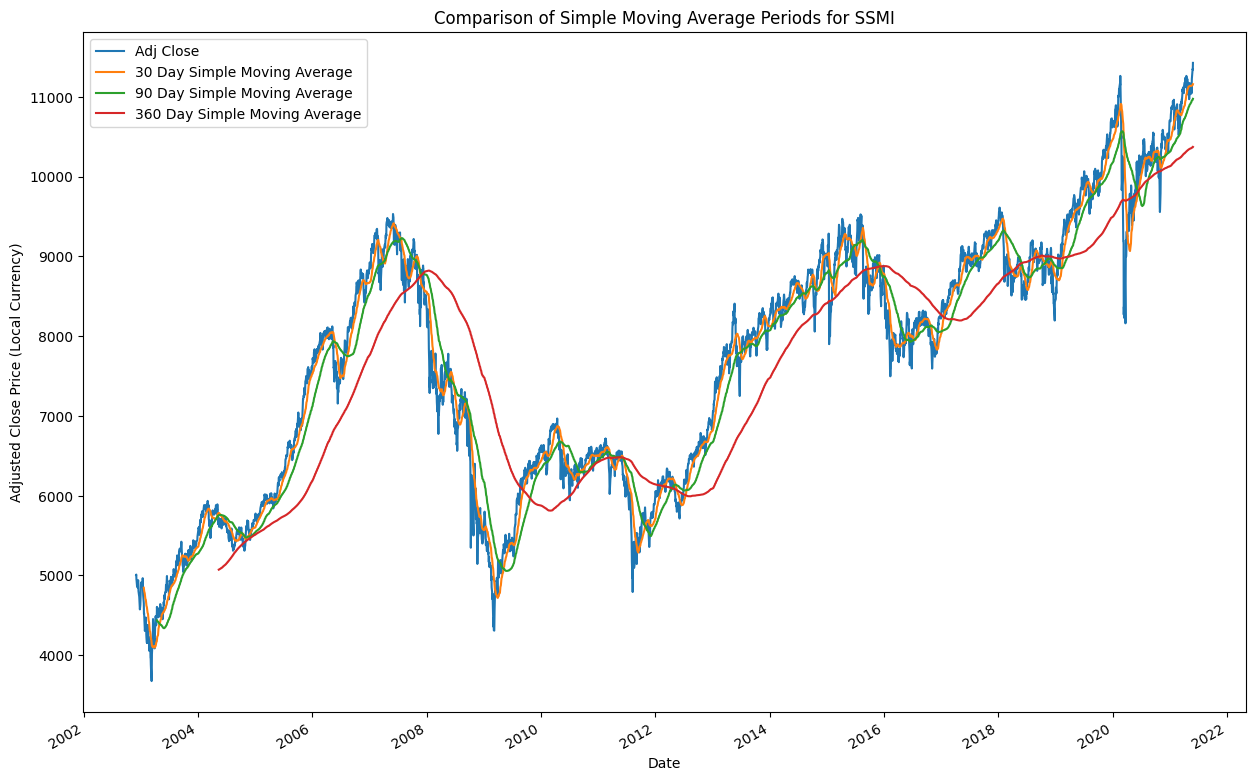

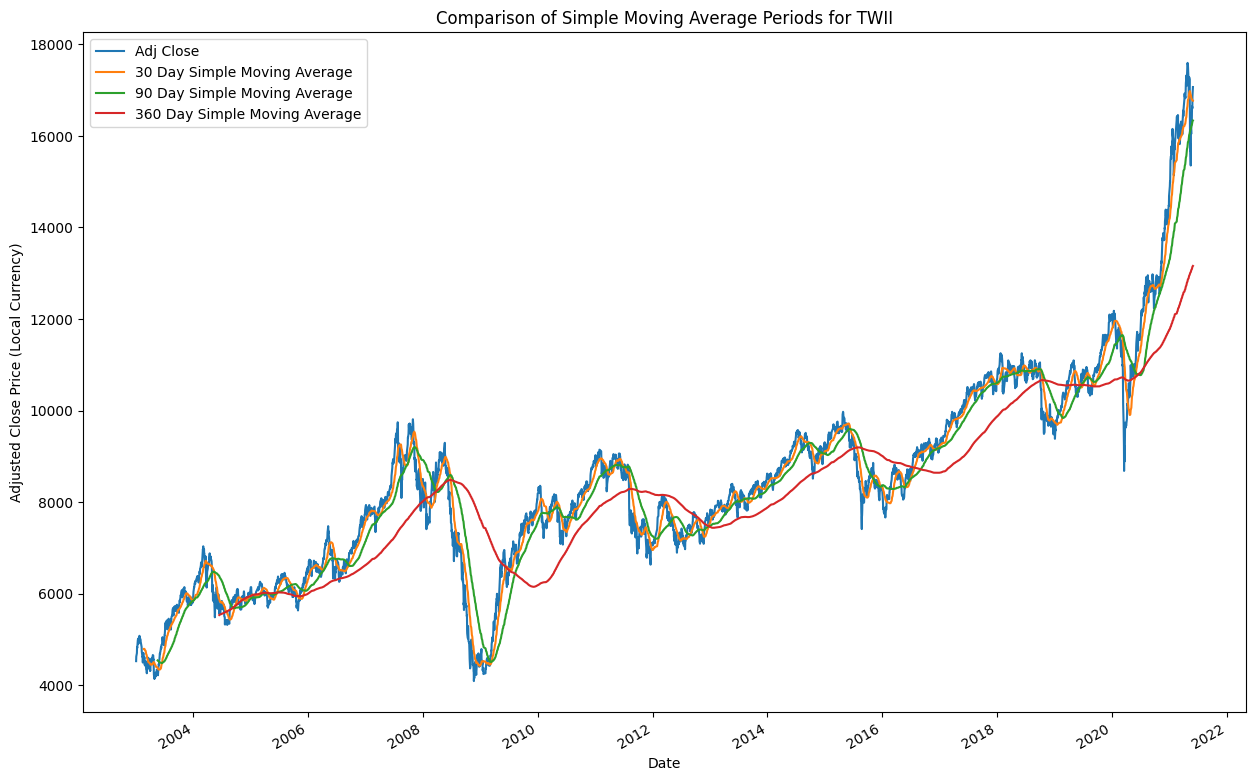

In [10]:
# Calculate simple moving averages for each index.
for index in data_frames_per_index.keys():
    # Increasing the window size smooths the data, but reduces the accuracy.
    data_frames_per_index[index]["30 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(90, min_periods=90).mean()
    )
    data_frames_per_index[index]["360 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(360, min_periods=360).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Simple Moving Average",
            "90 Day Simple Moving Average",
            "360 Day Simple Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Simple Moving Average Periods for {index}",
        figsize=(15, 10),
    )


### Calculate Exponential Moving Averages


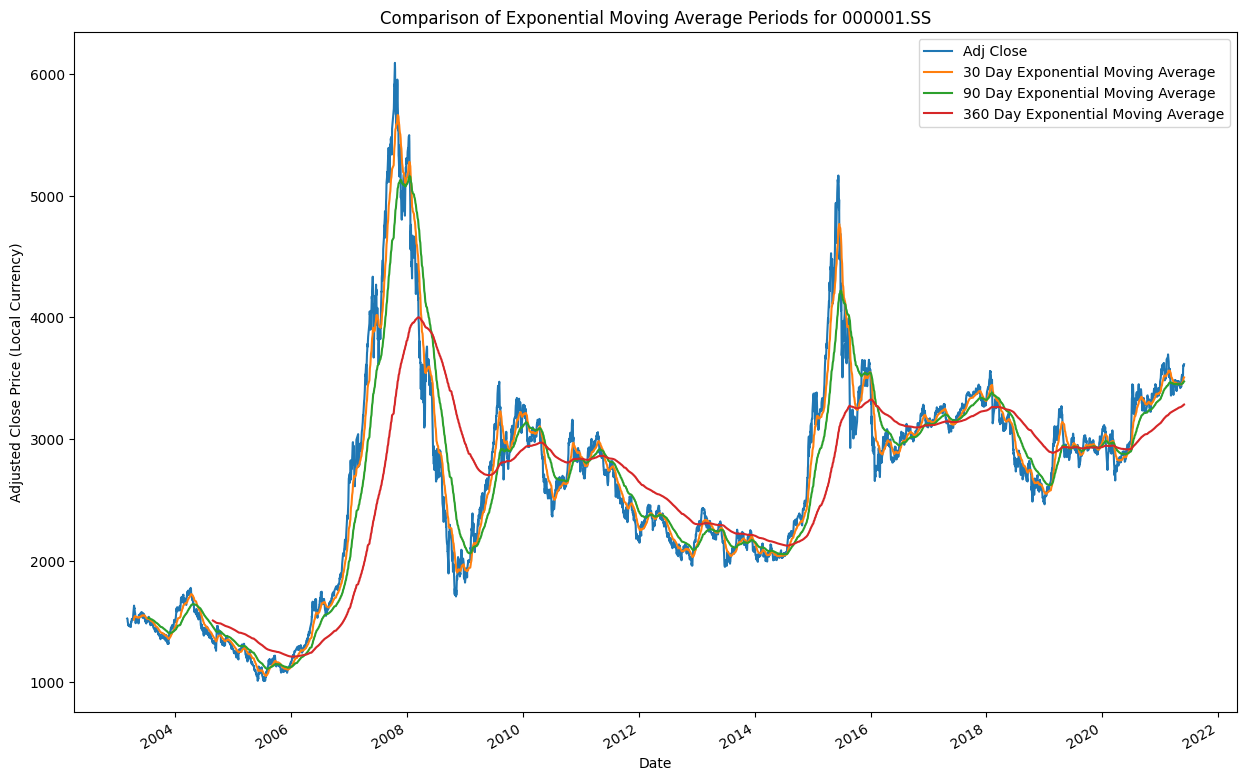

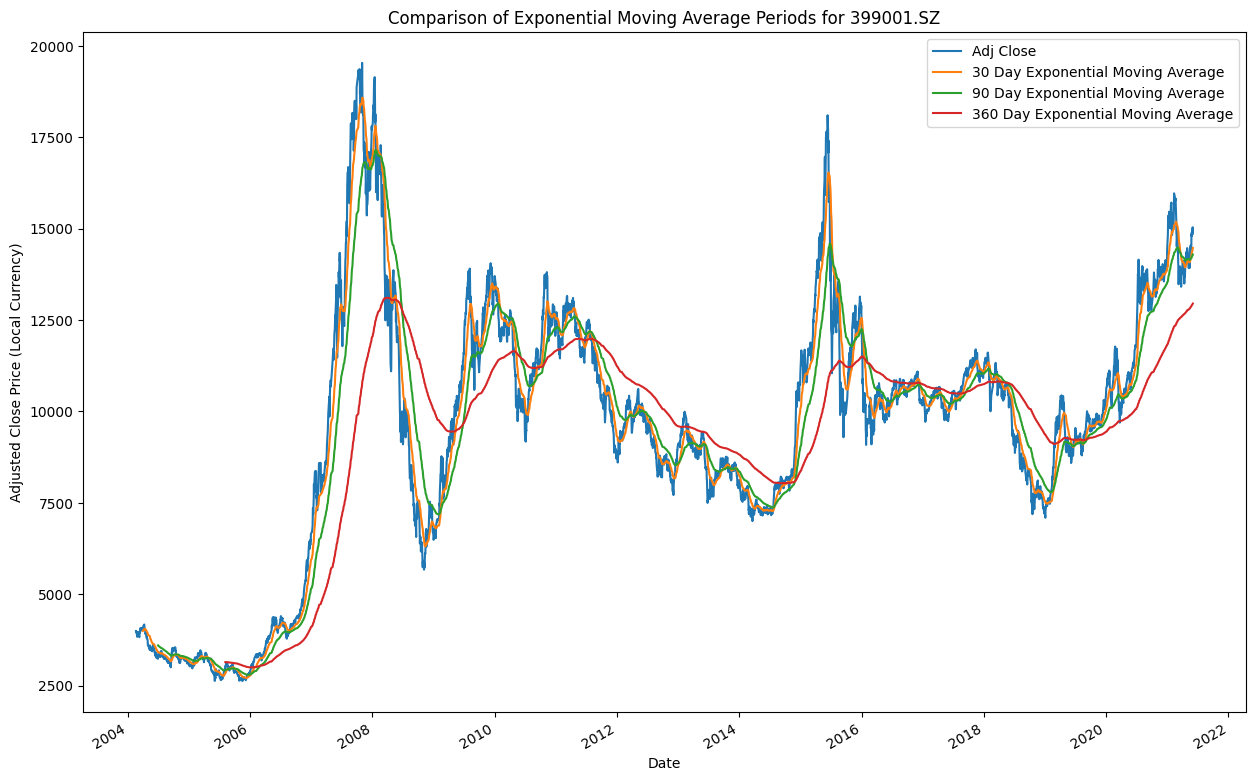

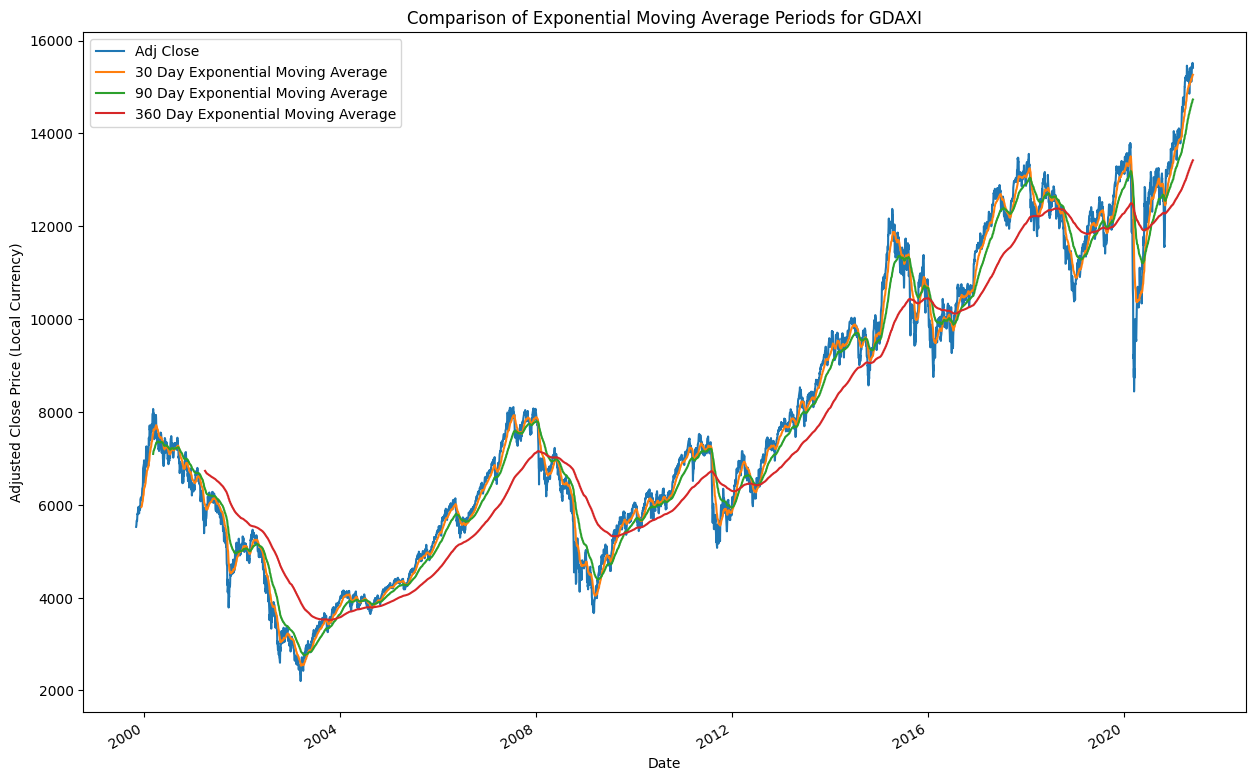

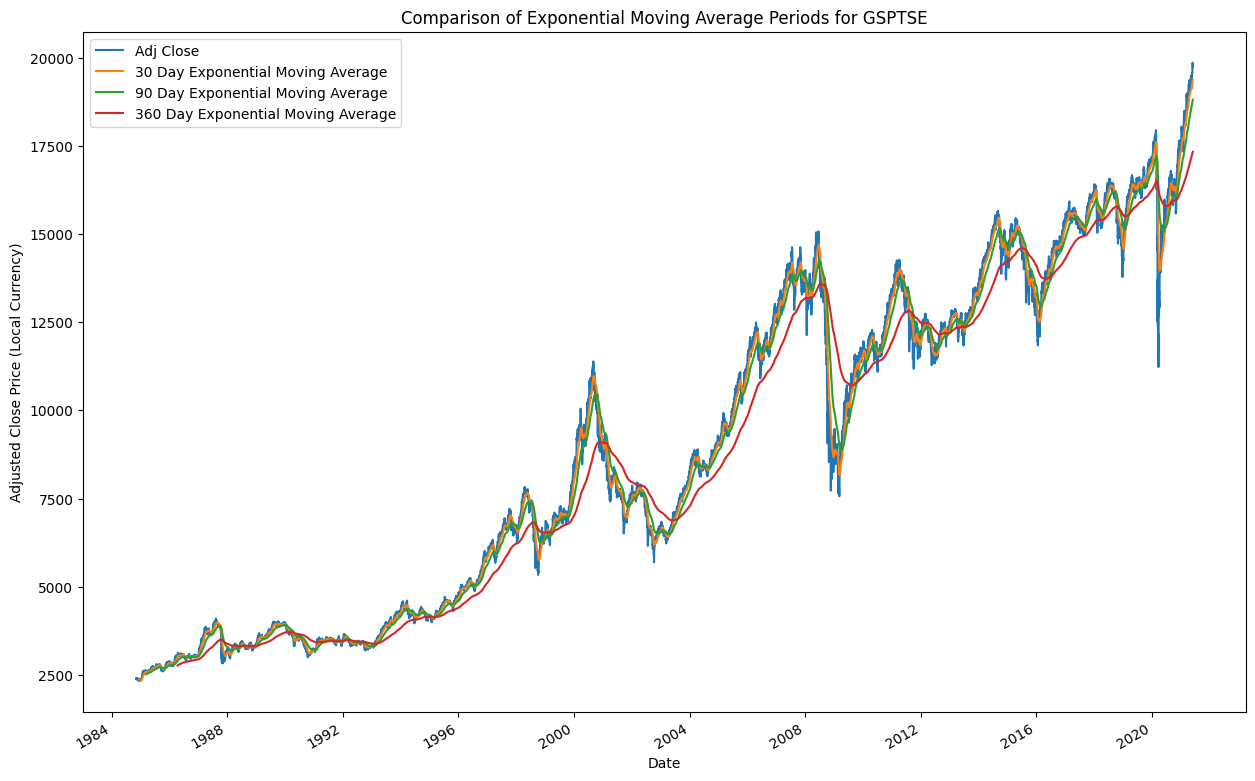

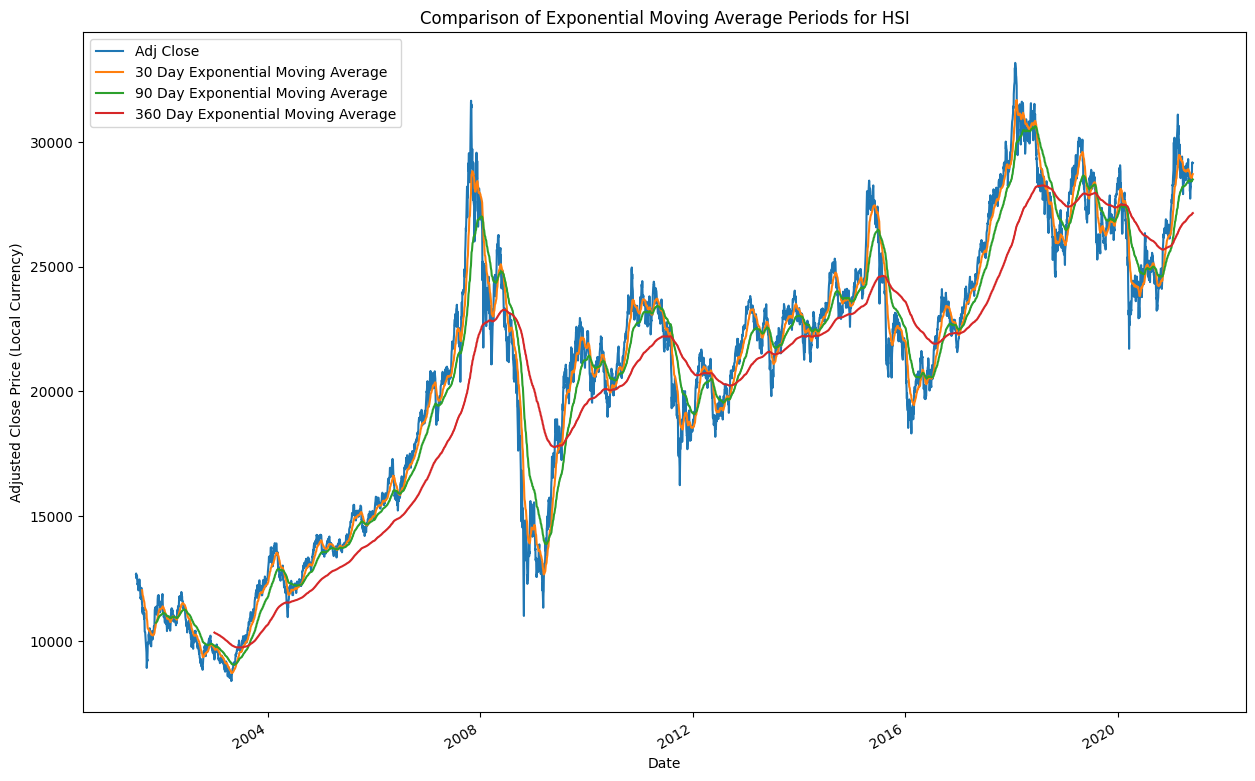

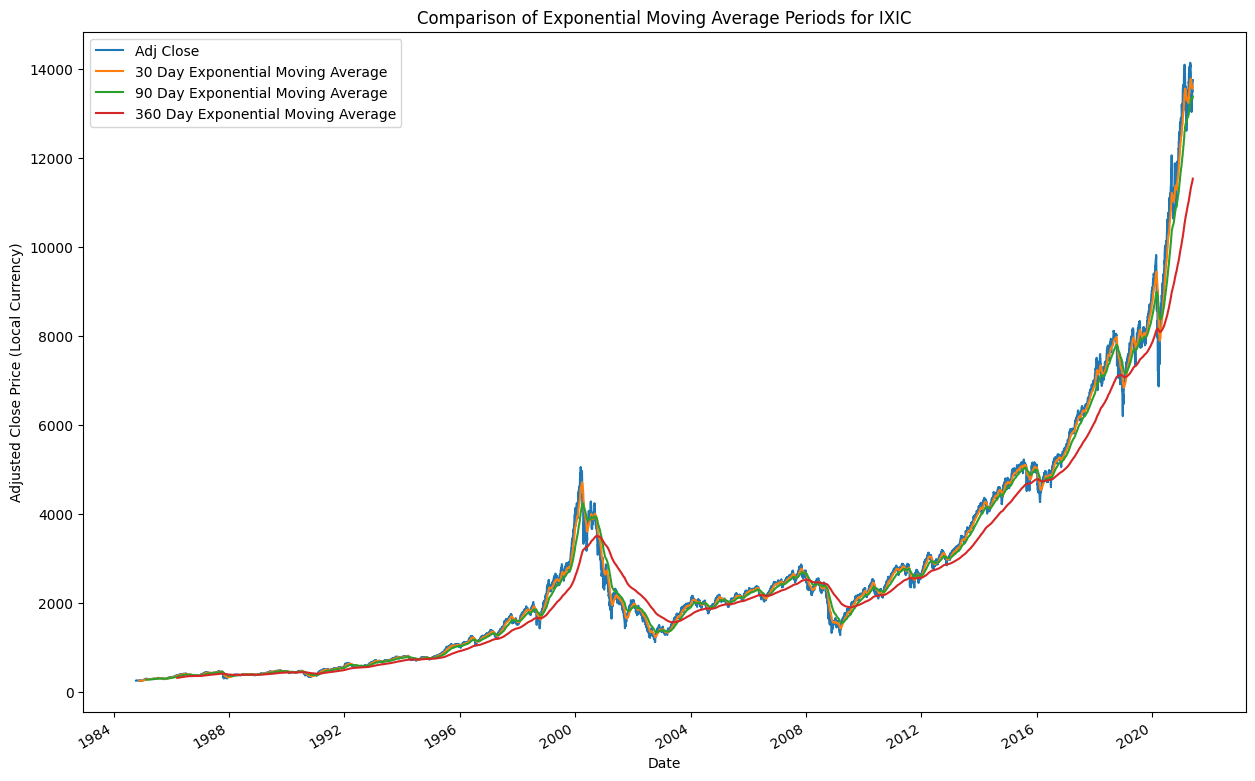

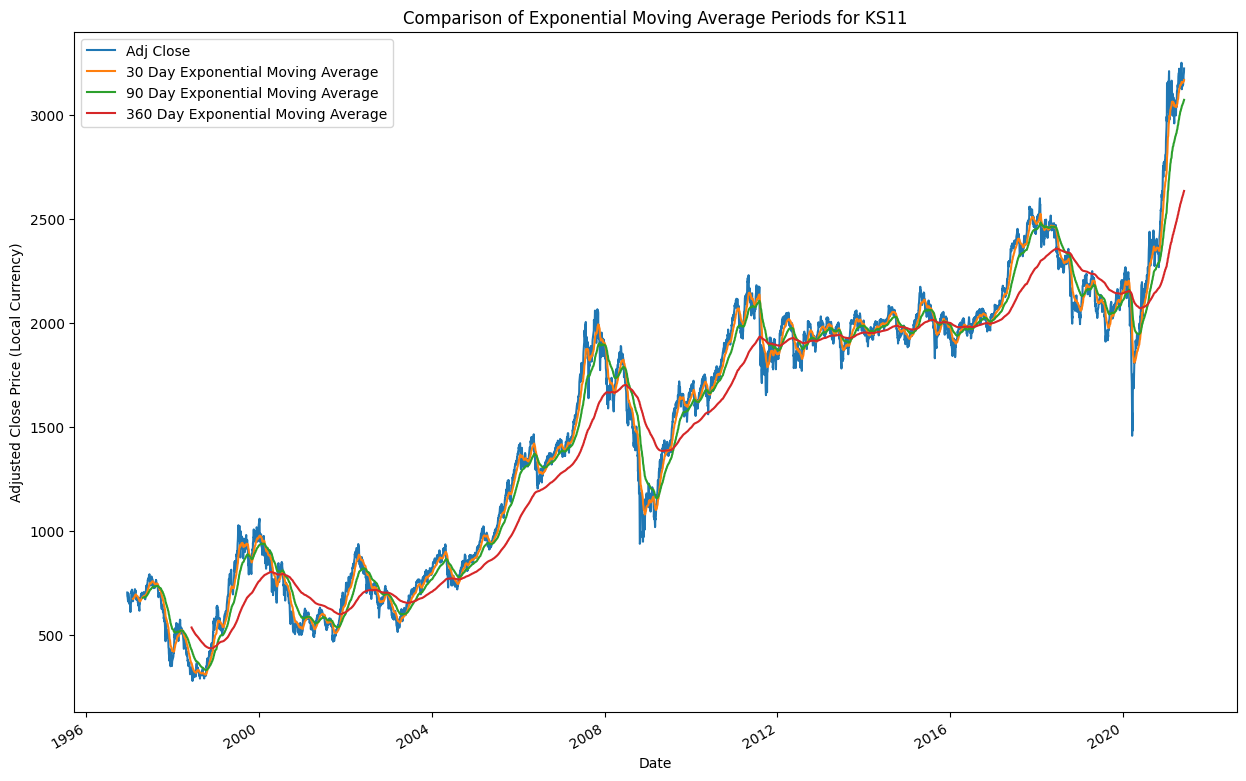

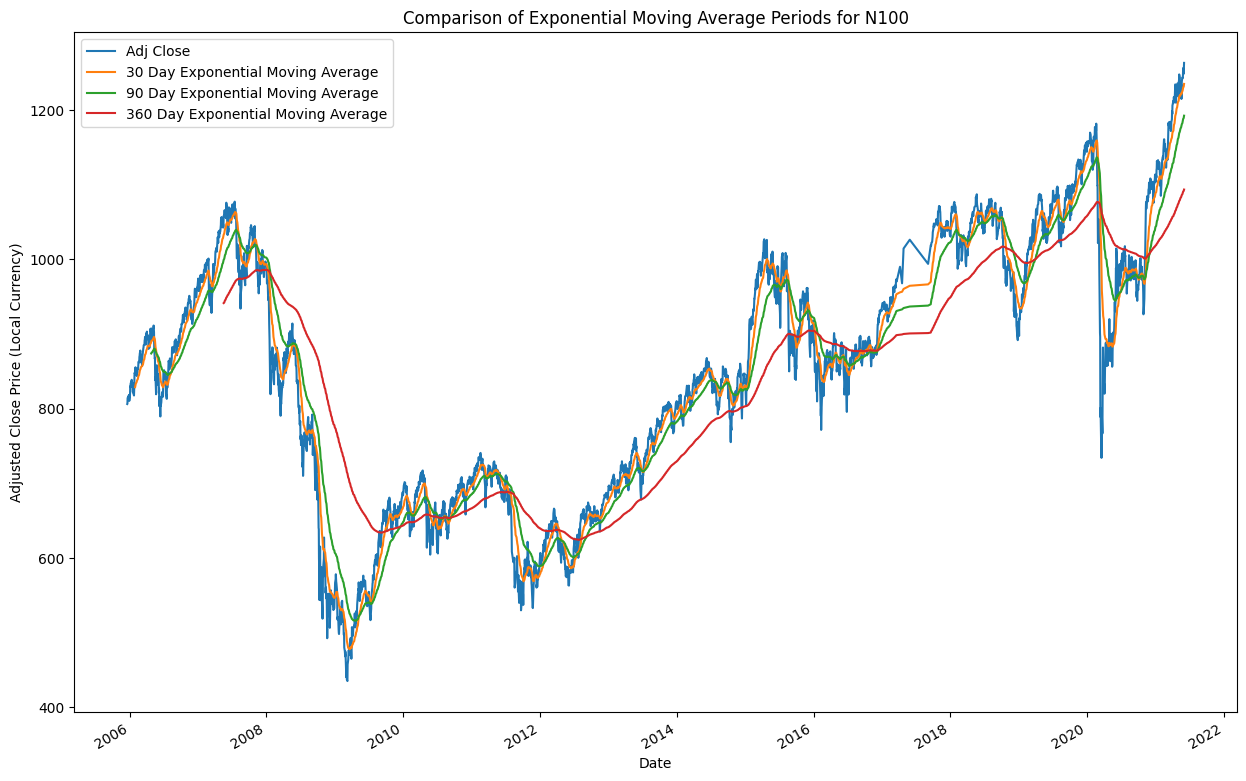

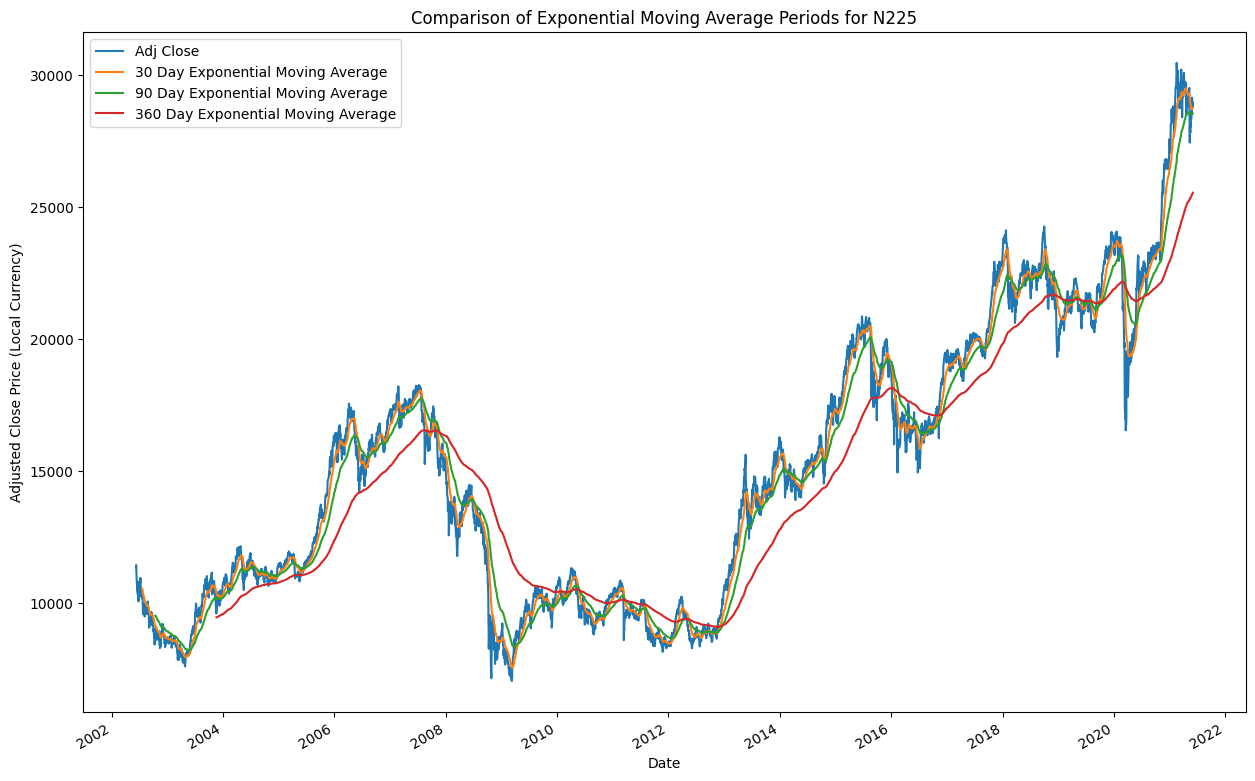

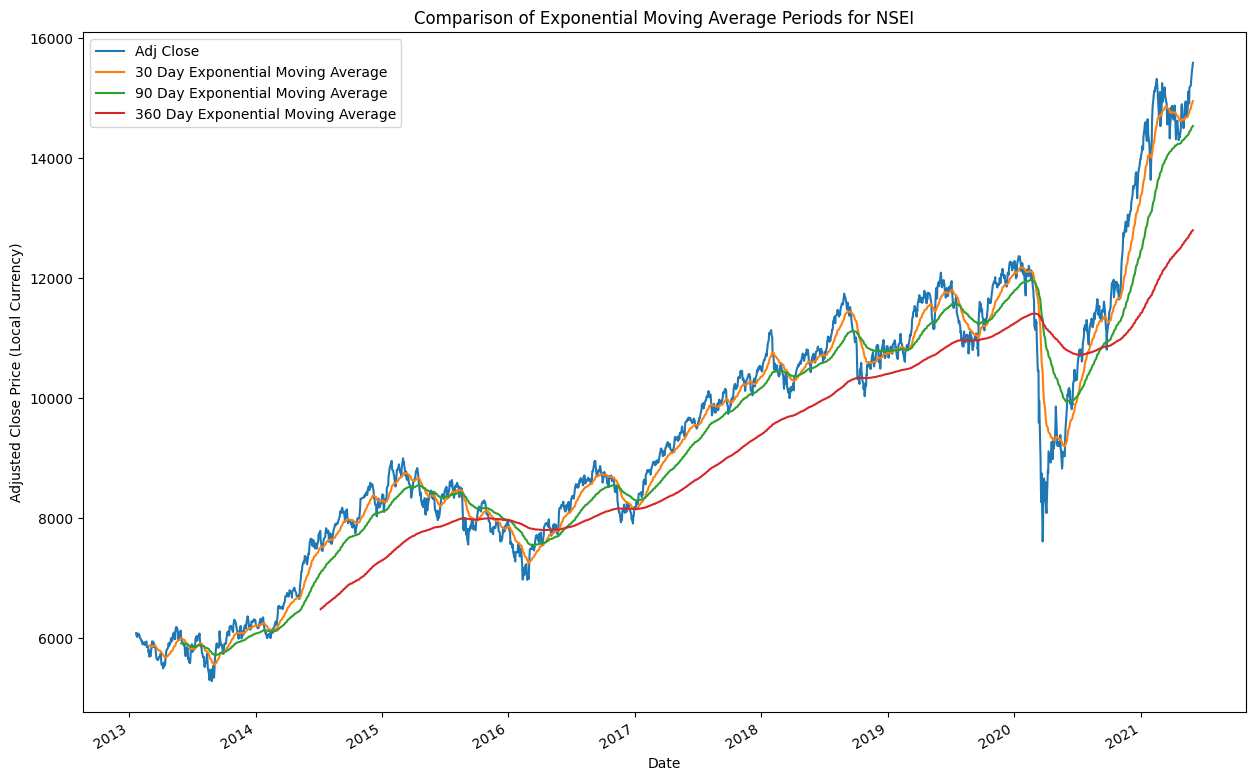

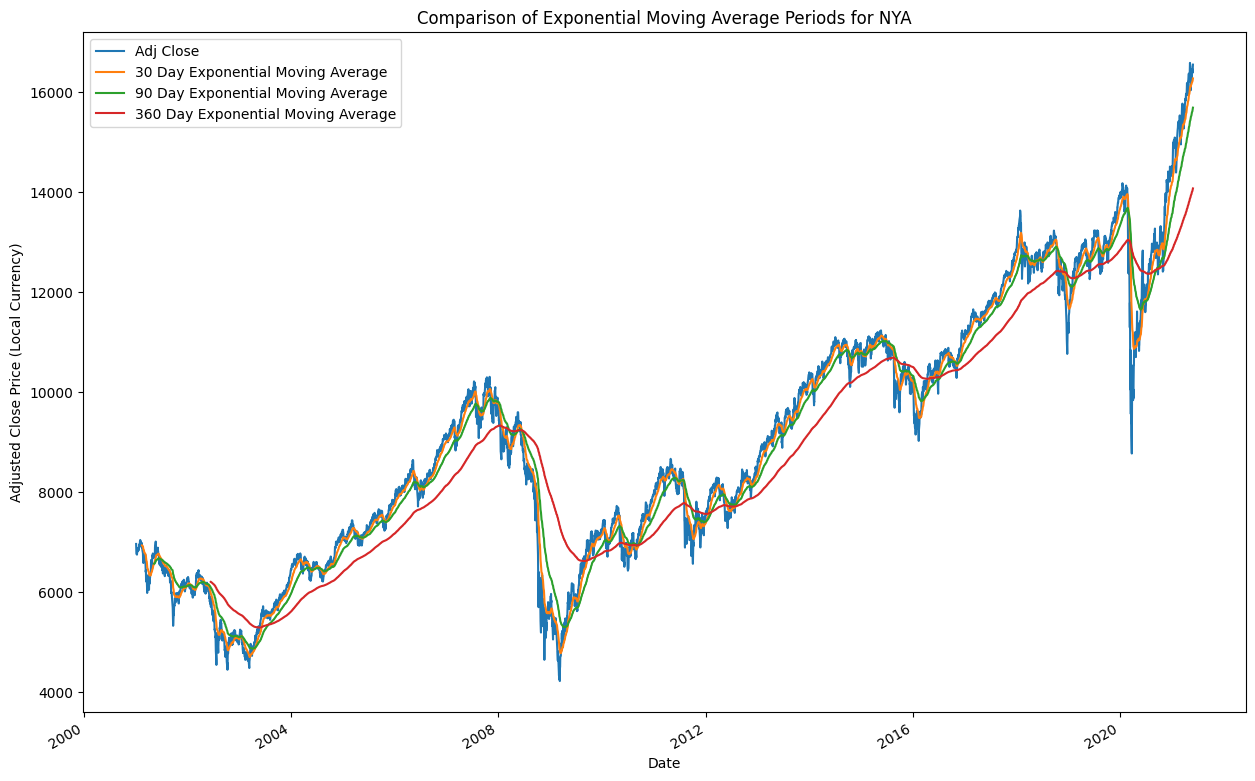

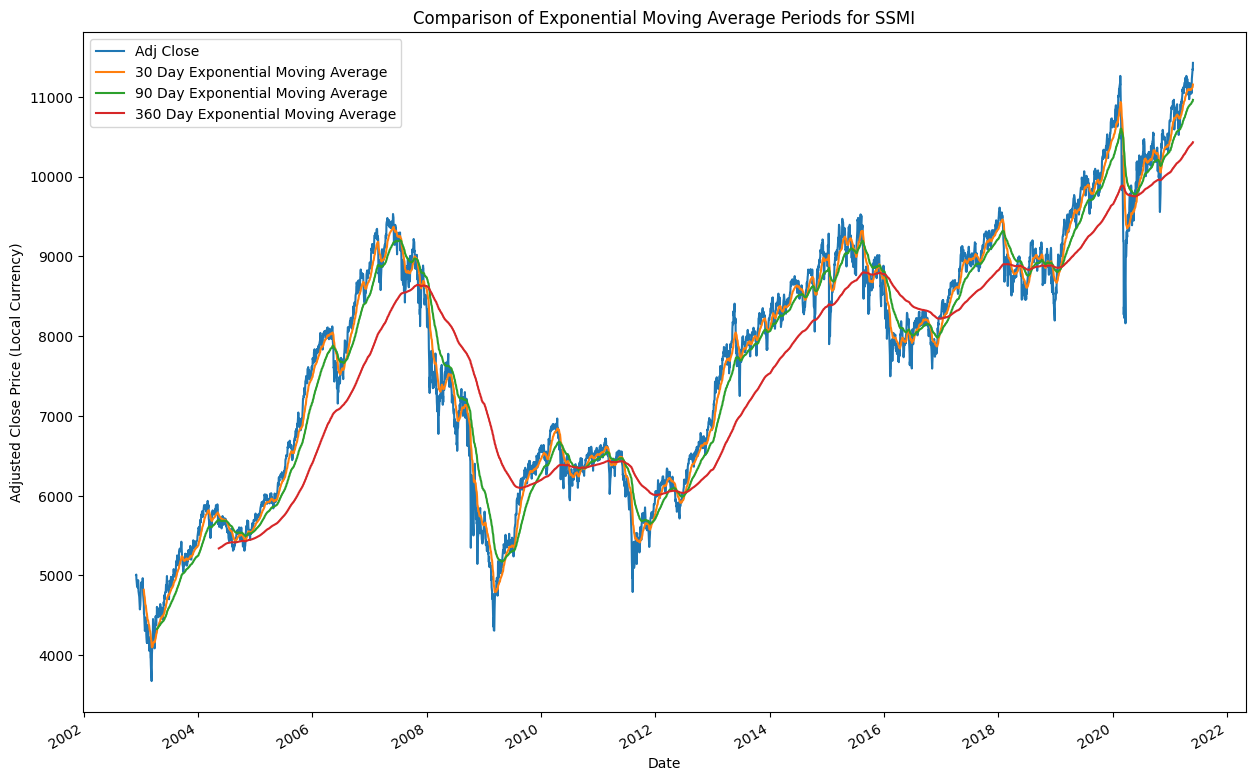

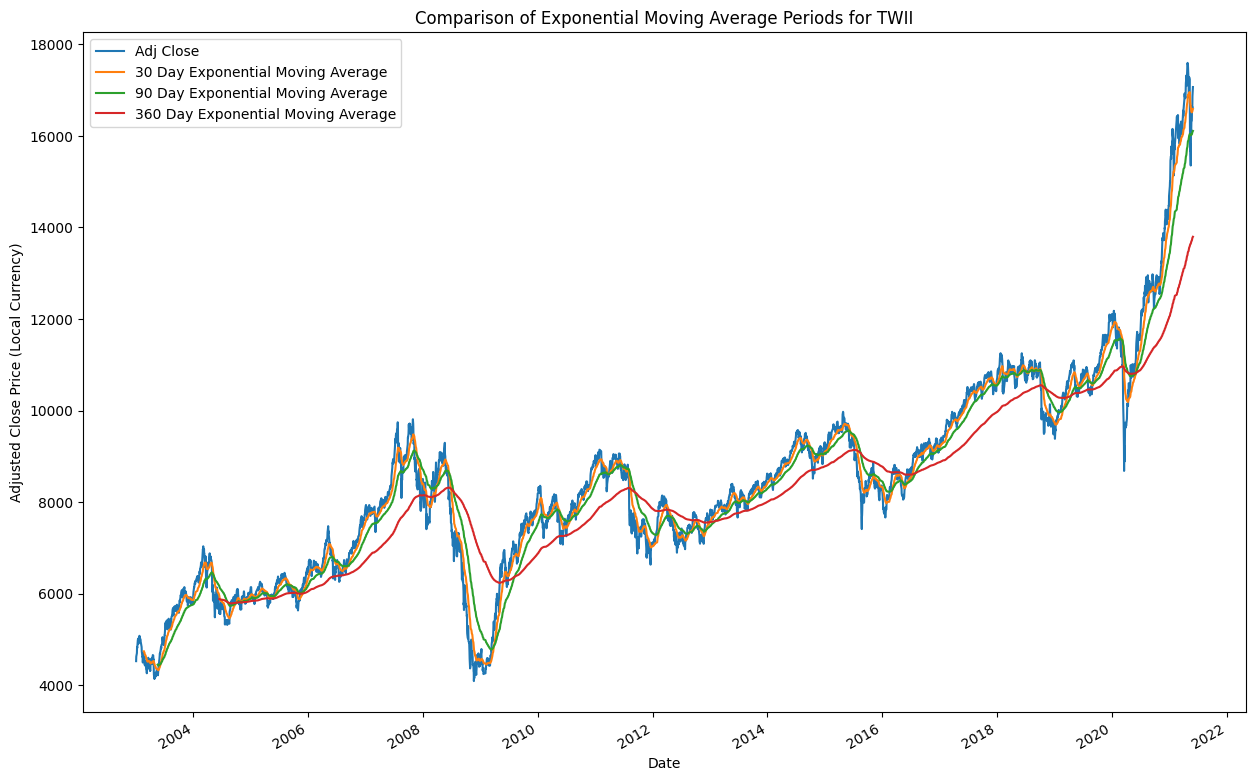

In [11]:
for index in data_frames_per_index.keys():
    # Increasing the window size smooths the data, but reduces the accuracy.
    data_frames_per_index[index]["30 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=90, min_periods=90).mean()
    )
    data_frames_per_index[index]["360 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=360, min_periods=360).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Exponential Moving Average",
            "90 Day Exponential Moving Average",
            "360 Day Exponential Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Exponential Moving Average Periods for {index}",
        figsize=(15, 10),
    )


## Data Filtering


### Compare Moving Average Strategy


<AxesSubplot: title={'center': 'Comparison of Moving Average Strategies for Nasdaq Composite (IXIC) - Last 5 Years'}, xlabel='Date', ylabel='Adjusted Close Price (USD)'>

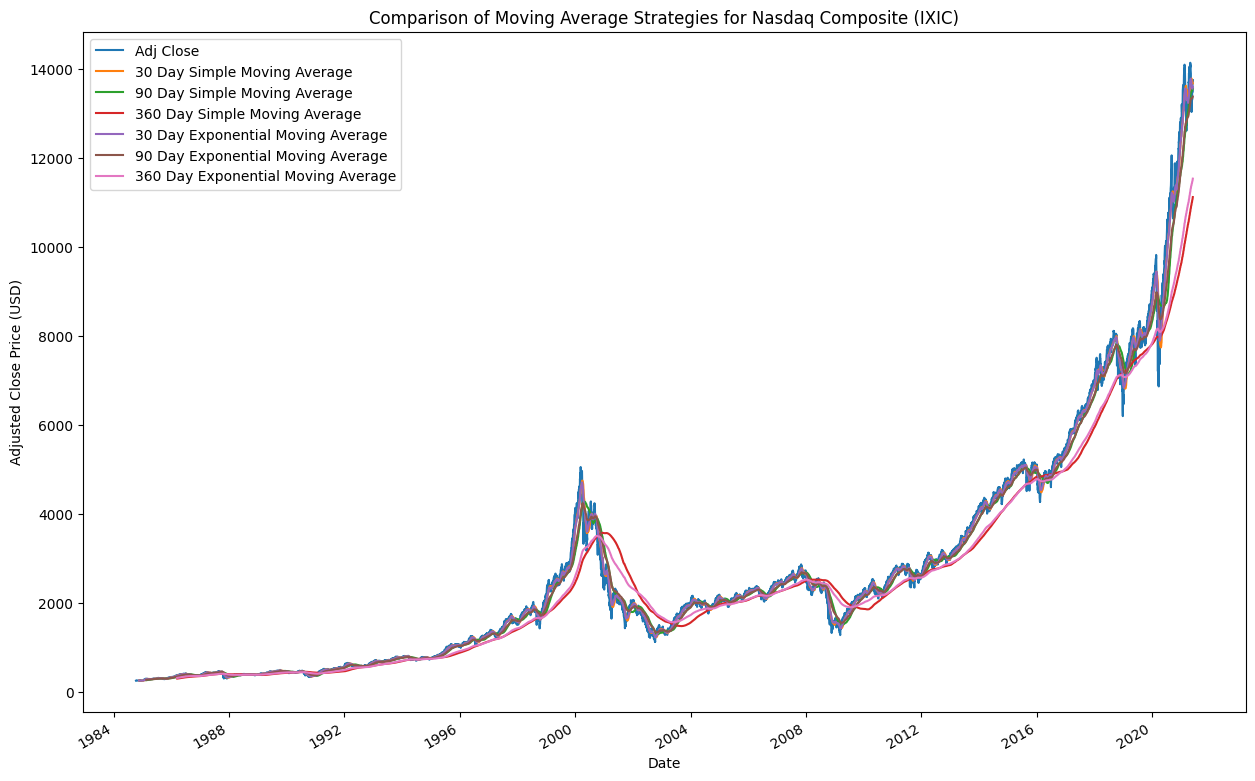

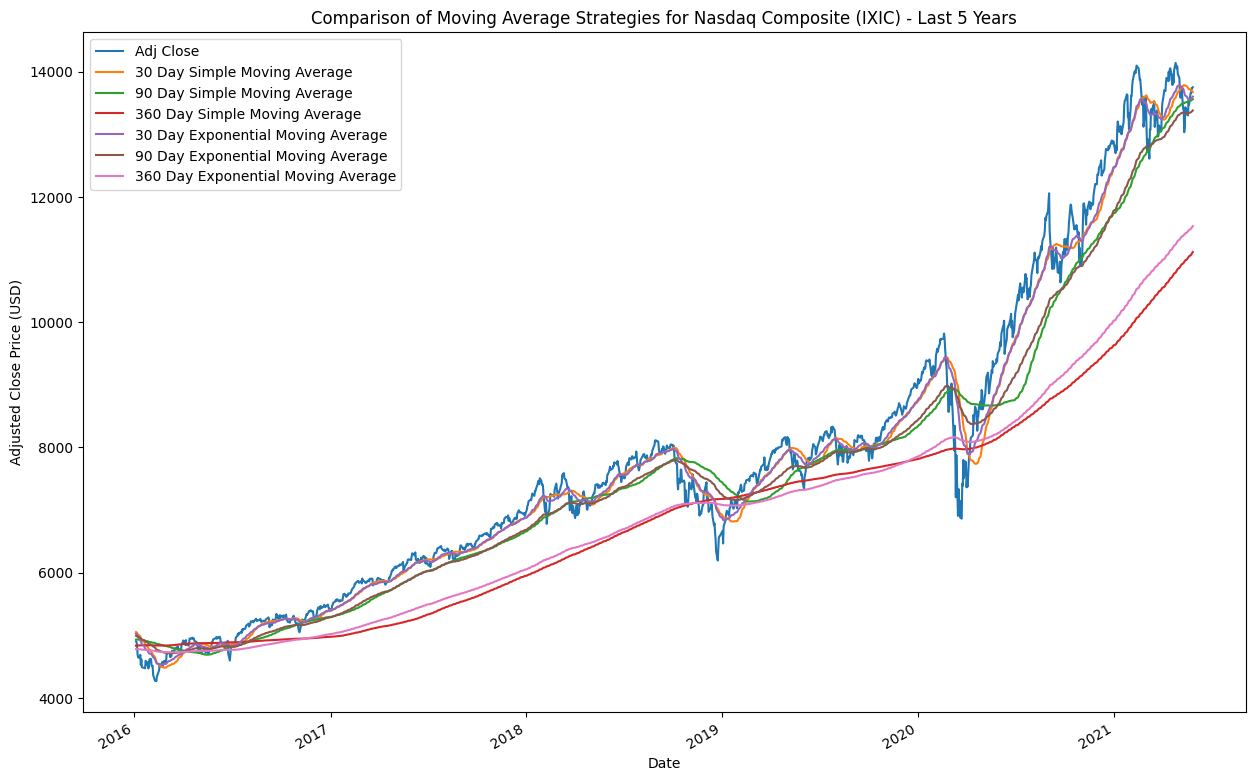

In [12]:
# Plot the IXIC data to compare how the moving average strategies perform.
ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "360 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
        "360 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for Nasdaq Composite (IXIC)",
    figsize=(15, 10),
)

# Plot the IXIC data from the last five years to zoom into how the moving
# average strategies perform.
ixic_data_last_5y = ixic_data[(ixic_data["Date"] > "2016-01-01")]
ixic_data_last_5y.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "360 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
        "360 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for Nasdaq Composite (IXIC) - Last 5 Years",
    figsize=(15, 10),
)


### Remove Unnecessary Columns


In [13]:
# Drop the columns that aren't relevant to our models.
ixic_data.drop(
    [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "360 Day Simple Moving Average",
        "360 Day Exponential Moving Average",
    ],
    axis=1,
    inplace=True,
)


### Shift Data to Prepare Target Variables


In [14]:
# Shift moving averages to the future by 30 days so they can be used to predict
# the adjusted close price 30 days in advance.
ixic_data["30 Day Exponential Moving Average"] = ixic_data[
    "30 Day Exponential Moving Average"
].shift(30)
ixic_data["90 Day Exponential Moving Average"] = ixic_data[
    "90 Day Exponential Moving Average"
].shift(30)
ixic_data["30 Day Simple Moving Average"] = ixic_data[
    "30 Day Simple Moving Average"
].shift(30)
ixic_data["90 Day Simple Moving Average"] = ixic_data[
    "90 Day Simple Moving Average"
].shift(30)
# Remove the first 30 rows of data since they now contain NaN values.
ixic_data.dropna(inplace=True)
ixic_data.reset_index(drop=True, inplace=True)
display(ixic_data)


Index       Date     Adj Close  30 Day Simple Moving Average  \
0     IXIC 1985-04-02    279.700012                    272.713334   
1     IXIC 1985-04-03    277.899994                    274.090000   
2     IXIC 1985-04-04    277.399994                    275.413333   
3     IXIC 1985-04-08    276.500000                    276.596667   
4     IXIC 1985-04-09    276.600006                    277.656667   
...    ...        ...           ...                           ...   
9109  IXIC 2021-05-24  13661.169920                  13301.169727   
9110  IXIC 2021-05-25  13657.169920                  13314.745378   
9111  IXIC 2021-05-26  13738.000000                  13331.380371   
9112  IXIC 2021-05-27  13736.280270                  13366.080697   
9113  IXIC 2021-05-28  13748.740230                  13410.376367   

      90 Day Simple Moving Average  30 Day Exponential Moving Average  \
0                       254.741111                         274.788998   
1                       255.214444                         275.598031   
2                       255.667778                         276.335237   
3                       256.095556                         276.972966   
4                       256.503333                         277.427183   
...                            ...                                ...   
9109                  13202.337674                       13430.406332   
9110                  13220.570888                       13466.902673   
9111                  13237.331663                       13492.124426   
9112                  13255.793664                       13527.391222   
9113                  13273.439323                       13561.258875   

      90 Day Exponential Moving Average  
0                            262.044035  
1                            262.683781  
2                            263.297665  
3                            263.873972  
4                            264.378808  
...                                 ...  
9109                       13046.872676  
9110                       13067.734807  
9111                       13085.099752  
9112                       13106.059313  
9113                       13126.856687  

[9114 rows x 7 columns]

## Forecasting with Regression Models


### Generate Training and Test Datasets for IXIC Index


In [15]:
# Set the 30 day and 90 day moving averages as the input variables.
x = ixic_data[
    [
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
    ]
]
# Set the adjusted close price as the target variable.
y = ixic_data[["Adj Close"]]
print("Input Variables:")
display(x)
print("Target Variable:")
display(y)

# Generate a training and test dataset for the IXIC index.
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=0.8,
    shuffle=False,
    random_state=69,
)
print("Training Data:")
display(x_train)
display(y_train)
print("Test Data:")
display(x_test)
display(y_test)

# Store the results of each model for comparison at the end.
model_results = {
    "Model": ["Ridge Regression", "LASSO Regression", "Polynomial Regression", "Last Value Benchmark"],
    "R^2 Score": [],
}


Input Variables:


30 Day Exponential Moving Average  90 Day Exponential Moving Average  \
0                            274.788998                         262.044035   
1                            275.598031                         262.683781   
2                            276.335237                         263.297665   
3                            276.972966                         263.873972   
4                            277.427183                         264.378808   
...                                 ...                                ...   
9109                       13430.406332                       13046.872676   
9110                       13466.902673                       13067.734807   
9111                       13492.124426                       13085.099752   
9112                       13527.391222                       13106.059313   
9113                       13561.258875                       13126.856687   

      30 Day Simple Moving Average  90 Day Simple Moving Average  
0                       272.713334                    254.741111  
1                       274.090000                    255.214444  
2                       275.413333                    255.667778  
3                       276.596667                    256.095556  
4                       277.656667                    256.503333  
...                            ...                           ...  
9109                  13301.169727                  13202.337674  
9110                  13314.745378                  13220.570888  
9111                  13331.380371                  13237.331663  
9112                  13366.080697                  13255.793664  
9113                  13410.376367                  13273.439323  

[9114 rows x 4 columns]

Target Variable:


Adj Close
0       279.700012
1       277.899994
2       277.399994
3       276.500000
4       276.600006
...            ...
9109  13661.169920
9110  13657.169920
9111  13738.000000
9112  13736.280270
9113  13748.740230

[9114 rows x 1 columns]

Training Data:


30 Day Exponential Moving Average  90 Day Exponential Moving Average  \
0                            274.788998                         262.044035   
1                            275.598031                         262.683781   
2                            276.335237                         263.297665   
3                            276.972966                         263.873972   
4                            277.427183                         264.378808   
...                                 ...                                ...   
7286                        4092.825876                        3939.800906   
7287                        4098.644853                        3945.146381   
7288                        4106.143887                        3951.074590   
7289                        4113.404923                        3956.956246   
7290                        4118.835578                        3962.244682   

      30 Day Simple Moving Average  90 Day Simple Moving Average  
0                       272.713334                    254.741111  
1                       274.090000                    255.214444  
2                       275.413333                    255.667778  
3                       276.596667                    256.095556  
4                       277.656667                    256.503333  
...                            ...                           ...  
7286                   4093.503320                   3930.756890  
7287                   4097.607658                   3936.581779  
7288                   4103.261654                   3942.747000  
7289                   4109.311320                   3948.441555  
7290                   4114.630656                   3953.647778  

[7291 rows x 4 columns]

Adj Close
0      279.700012
1      277.899994
2      277.399994
3      276.500000
4      276.600006
...           ...
7286  4292.060059
7287  4318.930176
7288  4308.120117
7289  4277.299805
7290  4351.970215

[7291 rows x 1 columns]

Test Data:


30 Day Exponential Moving Average  90 Day Exponential Moving Average  \
7291                        4125.733913                        3968.036222   
7292                        4133.299467                        3974.079382   
7293                        4138.820784                        3979.459613   
7294                        4138.133632                        3982.727971   
7295                        4134.615985                        3984.945161   
...                                 ...                                ...   
9109                       13430.406332                       13046.872676   
9110                       13466.902673                       13067.734807   
9111                       13492.124426                       13085.099752   
9112                       13527.391222                       13106.059313   
9113                       13561.258875                       13126.856687   

      30 Day Simple Moving Average  90 Day Simple Moving Average  
7291                   4121.050317                   3959.211665  
7292                   4127.066317                   3965.067554  
7293                   4132.070646                   3970.586442  
7294                   4134.326644                   3975.145551  
7295                   4136.986646                   3978.900109  
...                            ...                           ...  
9109                  13301.169727                  13202.337674  
9110                  13314.745378                  13220.570888  
9111                  13331.380371                  13237.331663  
9112                  13366.080697                  13255.793664  
9113                  13410.376367                  13273.439323  

[1823 rows x 4 columns]

Adj Close
7291   4357.970215
7292   4352.129883
7293   4336.220215
7294   4334.450195
7295   4307.189941
...            ...
9109  13661.169920
9110  13657.169920
9111  13738.000000
9112  13736.280270
9113  13748.740230

[1823 rows x 1 columns]

### Ridge Regression


#### Tune Alpha Hyperparameter for Ridge


In [16]:
# Use grid search to perform hyperparameter tuning on the ridge regression
# model.
parameters = [
    {
        "alpha": [
            0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            1.0,
            5.0,
            10.0,
            25.0,
            50.0,
            75.0,
            100.0,
            500.0,
            1000.0,
        ]
    }
]
model = Ridge()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)

# Display the results from the hyperparameter tuning.
alphas = parameters[0]["alpha"]
mean_test_scores = grid_search.cv_results_["mean_test_score"]
alphas_tested = pd.DataFrame({"Alpha": alphas, "Mean Test Score": mean_test_scores})
display(alphas_tested)
best_ridge_alpha = grid_search.best_params_["alpha"]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best R^2 Score: {grid_search.score(x_test, y_test)}")


Alpha  Mean Test Score
0      0.1         0.652964
1      0.2         0.652964
2      0.3         0.652964
3      0.4         0.652964
4      0.5         0.652964
5      0.6         0.652964
6      0.7         0.652964
7      0.8         0.652964
8      0.9         0.652964
9      1.0         0.652964
10     5.0         0.652964
11    10.0         0.652964
12    25.0         0.652963
13    50.0         0.652962
14    75.0         0.652961
15   100.0         0.652961
16   500.0         0.652947
17  1000.0         0.652931

Best Ridge Alpha: 0.1
Best R^2 Score: 0.9562331746434548


#### Predict using Ridge with Best Alpha Parameter


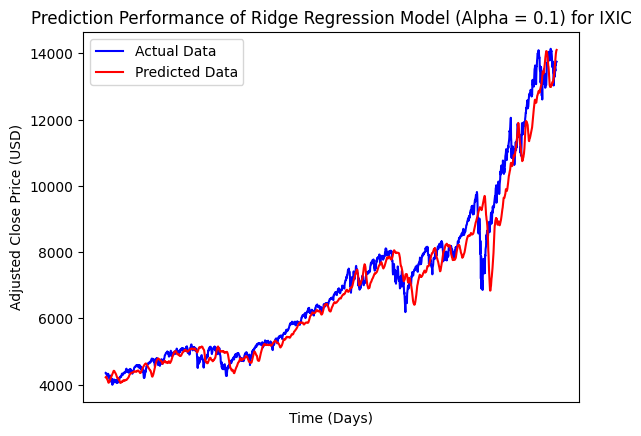

R^2 Score for Ridge Regression: 0.9562331746434548


In [17]:
# Define the ridge regression model.
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(x_train, y_train)
y_pred = ridge_model.predict(x_test)

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of Ridge Regression Model (Alpha = {best_ridge_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

ridge_score = ridge_model.score(x_test, y_test)
model_results["R^2 Score"].append(ridge_score)
print(f"R^2 Score for Ridge Regression: {ridge_score}")


### LASSO Regression


#### Tune Alpha Hyperparameter for LASSO


In [18]:
# Use grid search to perform hyperparameter tuning on the LASSO regression
# model.
parameters = [
    {
        "alpha": [
            0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            1.0,
            5.0,
            10.0,
            25.0,
            50.0,
            75.0,
            100.0,
            500.0,
            1000.0,
        ]
    }
]
model = Lasso()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)

# Display the results from the hyperparameter tuning.
alphas = parameters[0]["alpha"]
mean_test_scores = grid_search.cv_results_["mean_test_score"]
alphas_tested = pd.DataFrame({"Alpha": alphas, "Mean Test Score": mean_test_scores})
display(alphas_tested)
best_lasso_alpha = grid_search.best_params_["alpha"]
print(f"Best LASSO Alpha: {best_lasso_alpha}")
print(f"Best R^2 Score: {grid_search.score(x_test, y_test)}")


Alpha  Mean Test Score
0      0.1         0.566200
1      0.2         0.566211
2      0.3         0.566222
3      0.4         0.566233
4      0.5         0.566245
5      0.6         0.566256
6      0.7         0.566267
7      0.8         0.566278
8      0.9         0.566289
9      1.0         0.566301
10     5.0         0.566749
11    10.0         0.567308
12    25.0         0.568976
13    50.0         0.571728
14    75.0         0.574429
15   100.0         0.577083
16   500.0         0.597556
17  1000.0         0.616147

Best LASSO Alpha: 1000.0
Best R^2 Score: 0.9524363769299565


#### Predict Using LASSO with Optimal Alpha Parameter


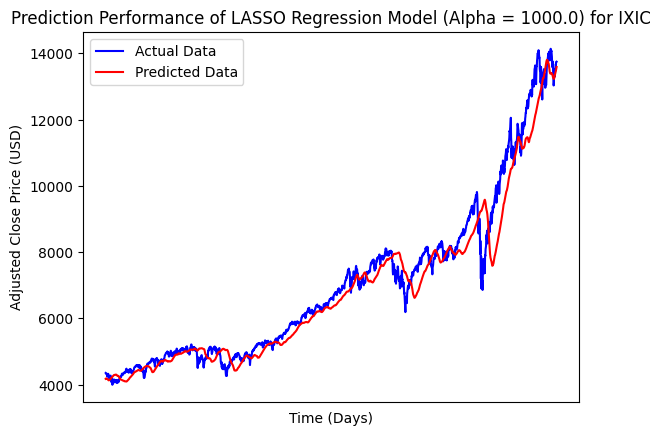

R^2 Score for LASSO Regression: 0.9524363769299565


In [19]:
# Define the LASSO regression model.
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(x_train, y_train)
y_pred = lasso_model.predict(x_test)

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of LASSO Regression Model (Alpha = {best_lasso_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

lasso_score = lasso_model.score(x_test, y_test)
model_results["R^2 Score"].append(lasso_score)
print(f"R^2 Score for LASSO Regression: {lasso_score}")

### Polynomial Regression


#### Tune Poly Degree Hyperparameter for Polynomial


In [20]:
# Use grid search to perform hyperparameter tuning on the polynomial regression
# model.
parameters = [{"poly__degree": [2, 3, 4, 5, 6, 7, 8]}]
pipeline = Pipeline(
    steps=[
        ("poly", PolynomialFeatures()),
        ("linear", LinearRegression()),
    ]
)
grid_search = GridSearchCV(
    cv=5,
    estimator=pipeline,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)

# Display the results from the hyperparameter tuning.
degrees = parameters[0]["poly__degree"]
mean_test_scores = grid_search.cv_results_["mean_test_score"]
degrees_tested = pd.DataFrame(
    {"Degree": degrees, "Mean Test Score": mean_test_scores}
)
display(degrees_tested)
best_poly_degree = grid_search.best_params_["poly__degree"]
print(f"Best Polynomial Degree: {best_poly_degree}")
print(f"Best R^2 Score: {grid_search.score(x_test, y_test)}")


Degree  Mean Test Score
0       2     8.047632e-01
1       3     3.682671e-01
2       4    -4.126681e+01
3       5    -2.445082e+03
4       6    -2.542428e+04
5       7    -5.283752e+05
6       8    -1.262192e+07

Best Polynomial Degree: 2
Best R^2 Score: 0.577302955693534


#### Predict Using Polynomial with Optimal Degree


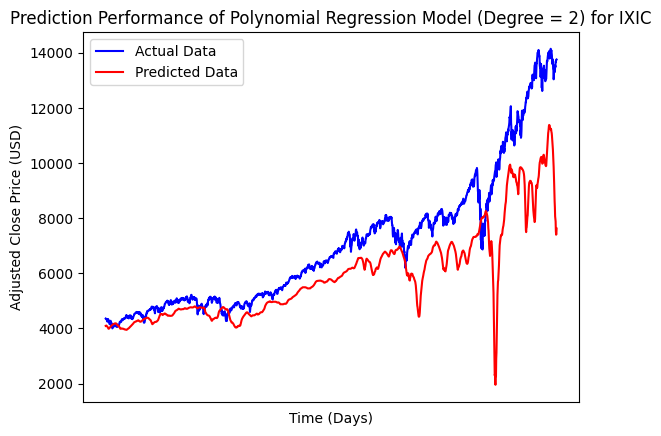

R^2 Score for Polynomial Regression: 0.577302955693534


In [21]:
# Fit polynomial regression with the optimal degree to the dataset.
poly_reg = PolynomialFeatures(degree=best_poly_degree)
x_train_poly = poly_reg.fit_transform(x_train)

# Define the polynomial regression model.
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
x_test_poly = poly_reg.fit_transform(x_test)
y_pred = poly_model.predict(x_test_poly)

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    "Prediction Performance of Polynomial Regression Model "
    f"(Degree = {best_poly_degree}) for IXIC"
)
plt.legend()
plt.show()

poly_score = poly_model.score(x_test_poly, y_test)
model_results["R^2 Score"].append(poly_score)
print(f"R^2 Score for Polynomial Regression: {poly_score}")


## Discussion of Results


### Comparison to Naive Benchmark (Last Value)


R^2 Score for Last Value (Naive Benchmark): 0.9602937357885344


Model  R^2 Score
0       Ridge Regression   0.956233
1       LASSO Regression   0.952436
2  Polynomial Regression   0.577303
3   Last Value Benchmark   0.960294

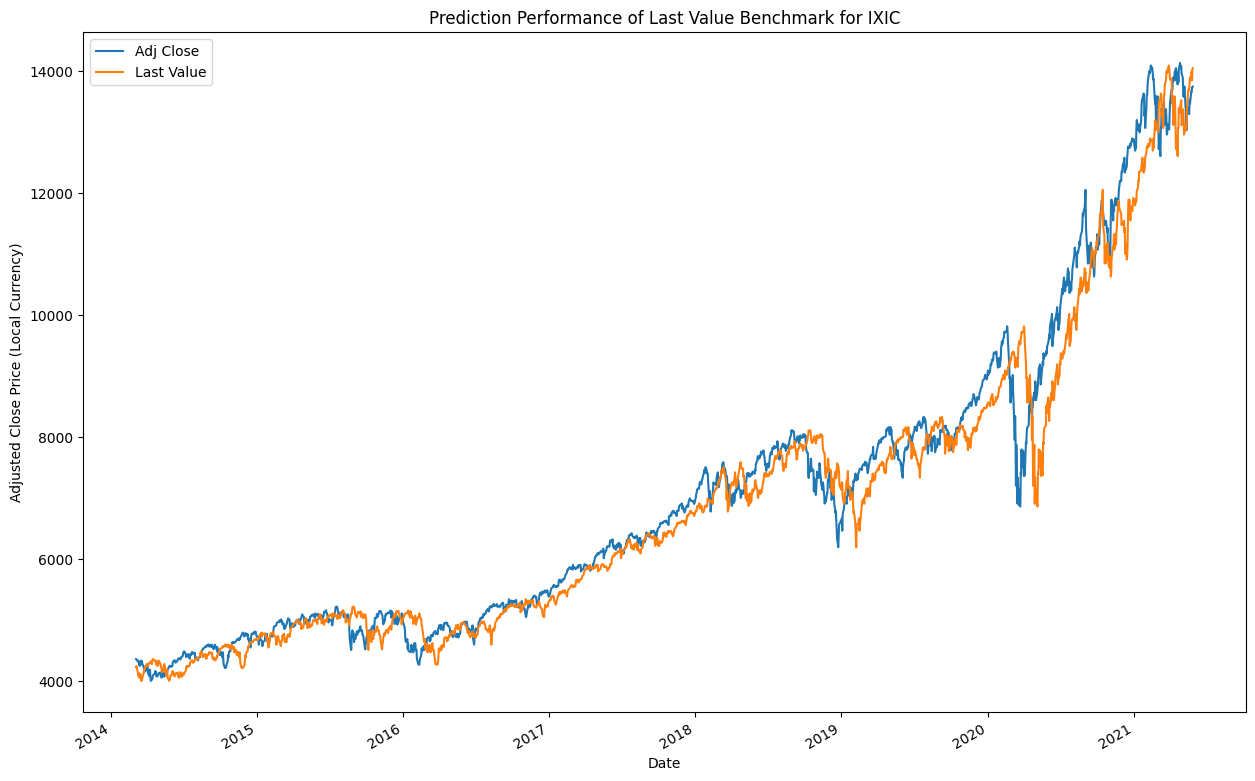

In [22]:
# Use 30 day old price as the prediction for that day.
ixic_data["Last Value"] = ixic_data["Adj Close"].shift(30)
# Remove values that are NaN.
ixic_data.dropna(inplace=True)
# Ensure that we use the same test data as the other models.
test_ixic_data = ixic_data.tail(len(y_test))

# Visualise how well the naive benchmark predicts prices 30 days in advance.
test_ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "Last Value",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (Local Currency)",
    title="Prediction Performance of Last Value Benchmark for IXIC",
    figsize=(15, 10),
)

# Calculate R^2 score for the naive benchmark.
last_value_score = metrics.r2_score(
    test_ixic_data["Adj Close"],
    test_ixic_data["Last Value"],
)
model_results["R^2 Score"].append(last_value_score)
print(f"R^2 Score for Last Value (Naive Benchmark): {last_value_score}")

# Show table of results to compare all models.
model_results_table = pd.DataFrame(model_results)
display(model_results_table)

### Use Log Returns as Target Variable


<AxesSubplot: title={'center': 'Historical Log Returns for Nasdaq Composite'}, xlabel='Date', ylabel='Log Return'>

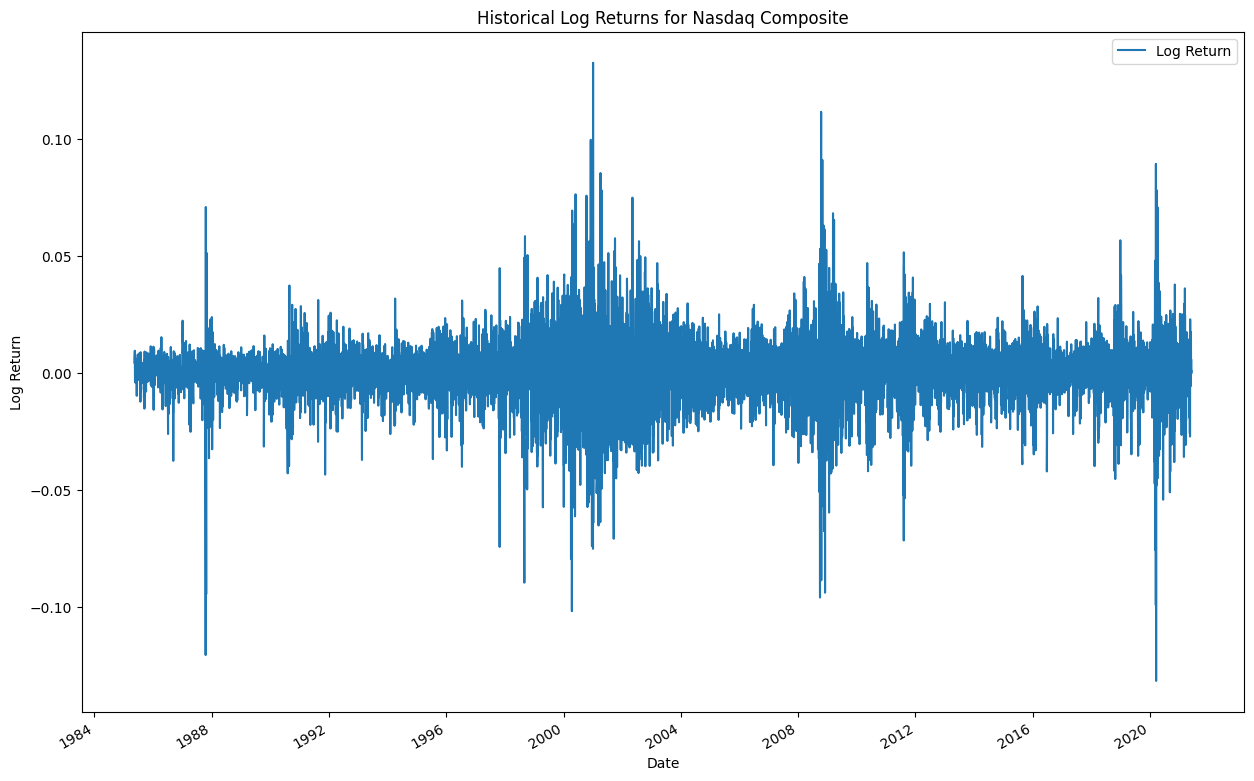

In [23]:
# Calculate log returns for Nasdaq Composite.
ixic_data["Log Return"] = np.log(
    ixic_data["Adj Close"] / ixic_data["Adj Close"].shift(1)
)

# Generate time series graph of log returns for Nasdaq Composite.
ixic_data.plot(
    x="Date",
    y=[
        "Log Return",
    ],
    xlabel="Date",
    ylabel="Log Return",
    title=f"Historical Log Returns for Nasdaq Composite",
    figsize=(15, 10),
)
